# Machine Learning Theory

## Trained ML Model

Let $\hat{f_A}$ be a trained ML model:

$$\hat{f_A} : \mathcal{X} \rightarrow \mathcal{Y} \quad x \mapsto \hat{f_A}(x)$$

In medical imaging, typically, $x$ is an image (or a video) and $y$ can be any type of output, for instance, a real number (regression), a class (classification), a segmentation map (segmentation), an image (image translation).

We will also consider simpler examples where $\mathcal{X} = \mathbb{R}$ or $\mathcal{X} = \mathbb{R^d}$.

## Ground-Truth Function

Let $g$ be the function which associates any input to the ground-truth prediction:

$$g : \mathcal{X} \rightarrow \mathcal{Y} \quad x \mapsto g(x)$$

**Note:** One could also denote $f$ the ground-truth function that $\hat{f_A}$ approximates but it can be convenient to have separate notations, in particular for the cases where the ground-truth itself will be uncertain or if we have multiple ground-truths (for example if we have multiple raters).

## Validation Metric

Let $metric$ be a validation metric:

$$metric : \mathcal{Y} \times \mathcal{Y} \rightarrow \mathbb{R} \quad (y, y') \mapsto metric(y, y')$$

**Note:** For example,
- Segmentation:
  - $metric(y, y') = \text{DSC}(y, y')$
  - $metric(y, y') = \text{HD}_{95}(y, y')$
- Classification:
  - $metric(y, y') = \delta_{y, y'}$
- Regression:
  - $metric(y, y') = |y - y'|$
  - $metric(y, y') = (y - y')^2$

## Model Performance

The performance of model $f$ on input $x$ will thus be:

$$metric(f(x), g(x))$$

## Random Variable $V_A$

Let $\Omega$ be the sample space corresponding to all possible inputs. Here we consider the case of a trained model (as opposed to a learning procedure), thus the only randomness comes from the test examples and we have $\Omega = \mathcal{X}$. One considers the following random variable $V_A$ which provides the performance of $\hat{f_A}$ according to the metric $metric$ on a given input $x$:

$$V_A : \Omega \rightarrow \mathbb{R} \quad x \mapsto V(x) = metric(\hat{f_A}(x), g(x))$$

We will assume that the first and second-order moments of $V_A$ exist and are denoted respectively $\mu_A$ and $\sigma_A^2$.

For a given $x \in \mathcal{X}$, we denote $v_A = V_A(x)$ the realization of $v_A$. We have access to a test sample $S_{test} = (x^{(1)}, \ldots, x^{(n)}) \subset \mathcal{X}$ of size $n$. The values of the performance metric on the test sample are $(v_A^{(1)} = V_A(x^{(1)}), \ldots, v_A^{(n)} = V_A(x^{(n)}))$. Let us denote $m_A$ the empirical mean on $S_{test}$ and $s_A^2$ the empirical variance.

## Questions/Aims

### Visualize the data and the quality of the model fits
- Provide descriptive statistics and graphs for the performance metric on the test samples.
  - Which statistics and graphs are the most adequate to describe the results (look at the empirical distribution of the metric)
- How precise is the estimation of $\mu_A$ by the empirical mean $m_A$?
  - Associated tools: standard error of the mean, confidence interval
  - Methods: parametric estimates (consider different cases when $n$ is small versus large and when $V_A$ is assumed to be Gaussian or not), bootstrap estimates
- Is model $\hat{f_A}$ obtained with method $A$ better/worse than model $\hat{f_B}$ obtained with method $B$?
  - Associated tools: confidence interval on the difference in performance, statistical tests (paired)
  - Methods: parametric tests, bootstrap tests


## 0 - Bibliothèques nécéssaires

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, norm
import seaborn as sns

## Datasets and experiments

### Experiment 1

Taken from~\cite{hothorn2005design}.

Data:
- $y=\beta_1 x + \beta_2 x^2 + \epsilon$
- $x \sim \mathcal{U}([0,5])$
- $\epsilon \sim \mathcal{N}(0,1)$
- $\beta_1=2$ is fixed
- $\beta_2$ varies from $0$ to $0.16$

Models are the following regression models trained using ordinary least squares:
- Model A: $f_A(x)=w_1 x + w_0$
- Model B: $f_B(x)=w_2 x^2 + w_1 x + w_0$

The performance metric is $metric(y,y')=(y-y')^2$.

The training set is fixed and is composed of $n_{train}=150$ observations simulated using the above formula. The simulation is done once.

The test set is composed of $n_{test}=2000$ observations simulated using the above formula. The simulation is done once for now. We will take subsets of the test set of varying sizes $n_{test} \leq 2000$.

- Plot the training and test sets on the same graph using different colors for dots.
- Train models A and B on the training set
- Plot the fitted models $\hat{f_A}$ and $\hat{f_B}$    
- Do this for a few different values of $\beta_2$ (maybe even try with higher values than $0.16$)
- In the remainder, for now, we will use only one (non-zero and sufficiently large) value of $\beta_2$.



## I - Introduction, variables, training and test sets

In [46]:
np.random.seed(42)

In [47]:
# Définition des premières variables

beta1 = 2
beta2_values = np.linspace(0, 0.16, 9)
M = [150,200,500,1000,2000]
n = 150
m = 2000
seed = 42

In [48]:
# Définition des ensembles d'entrainement, de test, coefficients des modèles

epsilon = np.random.normal(0, 1, n + m)
x = np.random.uniform(0, 5, n + m)

x_train = x[:n]
x_test = x[n:n+m]

epsilon_train = epsilon[:n]
epsilon_test = epsilon[n:n+m]

modele_A = []
modele_B = []


for beta2 in beta2_values:

          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train
          y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

           # Linear Model : A
          model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
          y_pred_a = model_a.predict(x_test.reshape(-1, 1))
          pa = (y_test - y_pred_a)**2

          coef_a = model_a.coef_[0]
          intercept_a = model_a.intercept_

          # Quadratic Model : B
          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_b = LinearRegression().fit(x_train_quad, y_train)
          y_pred_b = model_b.predict(x_test_quad)
          pb = (y_test - y_pred_b)**2

          coef_b = model_b.coef_
          intercept_b = model_b.intercept_

          y = beta1*x + beta2*x**2 +epsilon
          eq_a = intercept_a + coef_a * x
          modele_A.append([intercept_a, coef_a])
          eq_a_train = intercept_a + coef_a * x_train
          eq_a_test = intercept_a + coef_a * x_test
          eq_b = intercept_b + coef_b[0] * x + coef_b[1] * x**2
          modele_B.append([intercept_b, coef_b])
          eq_b_train = intercept_b + coef_b[0] * x_train + coef_b[1] * x_train**2
          eq_b_test = intercept_b + coef_b[0] * x_test + coef_b[1] * x_test**2



We first check our distributions of x and epsilon, using the random seed 42.

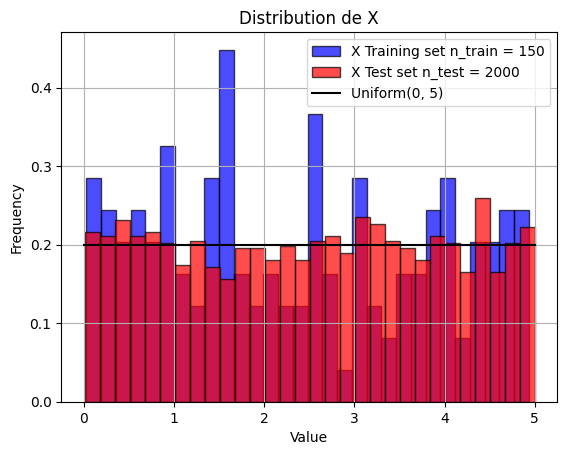

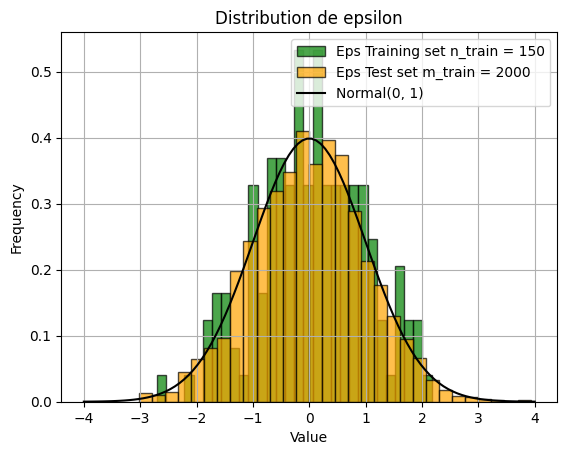

In [49]:
# Vérifier que la distribution de nos variables aléatoires est bien cohérente

def print_random_variables():

    np.random.seed(seed)

    x = np.random.uniform(0, 5, n + m)
    x_train = x[:n]
    x_test = x[n:n+m]

    epsilon = np.random.normal(0, 1, n + m)
    epsilon_train = epsilon[:n]
    epsilon_test = epsilon[n:n+m]

    x_vals = np.linspace(0, 5, 100)
    epsilon_vals = np.linspace(-4, 4, 100)

    plt.figure()
    plt.title("Distribution de X")
    plt.hist(x_train, bins=30, label="X Training set n_train = 150", color="blue", edgecolor='black', alpha=0.7, density=True)
    plt.hist(x_test, bins=30, label="X Test set n_test = 2000", color="red", edgecolor='black', alpha=0.7, density=True)
    plt.plot(x_vals, uniform.pdf(x_vals, 0, 5), 'k-', label="Uniform(0, 5)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.title("Distribution de epsilon")
    plt.hist(epsilon_train, bins=30, label="Eps Training set n_train = 150", color="green", edgecolor='black', alpha=0.7, density=True)
    plt.hist(epsilon_test, bins=30, label="Eps Test set m_train = 2000", color="orange", edgecolor='black', alpha=0.7, density=True)
    plt.plot(epsilon_vals, norm.pdf(epsilon_vals, 0, 1), 'k-', label="Normal(0, 1)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

print_random_variables()

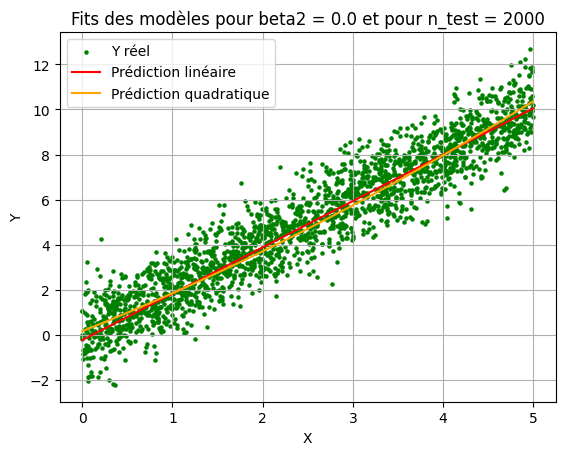

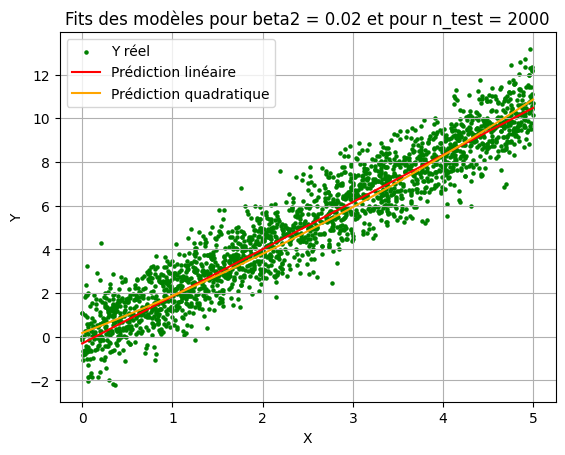

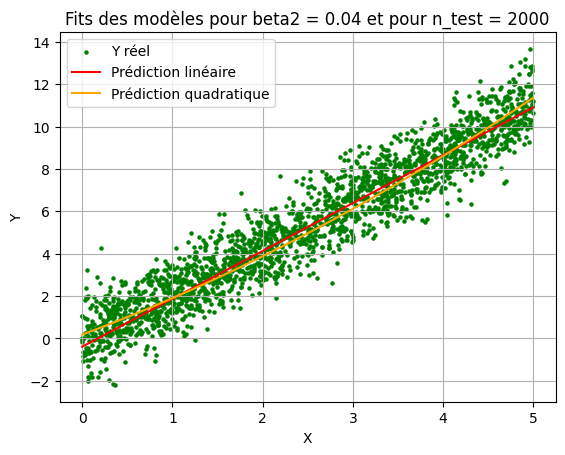

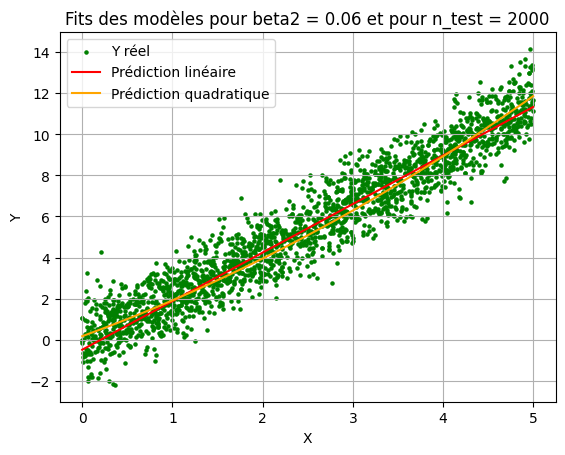

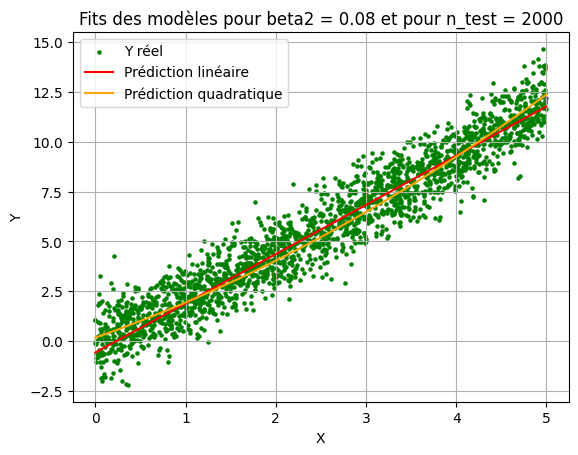

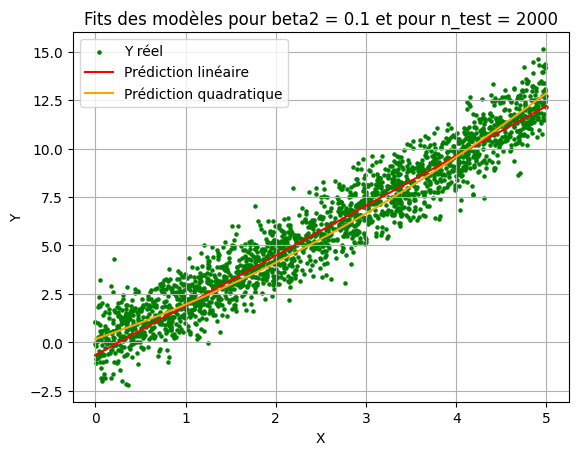

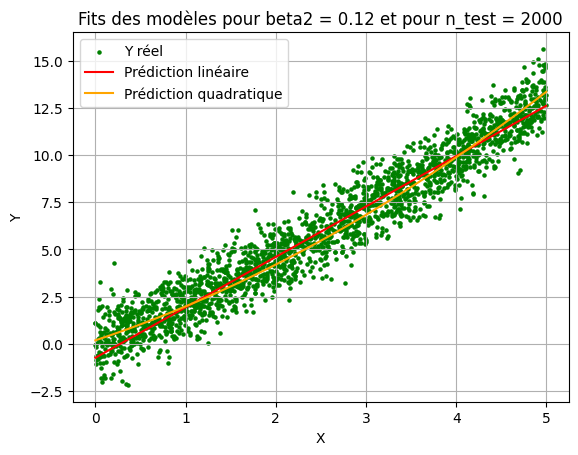

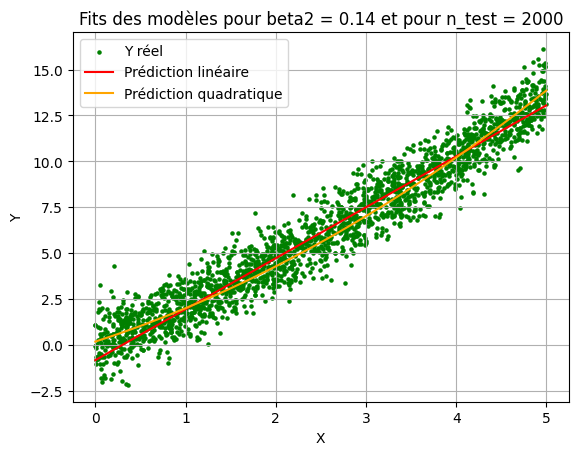

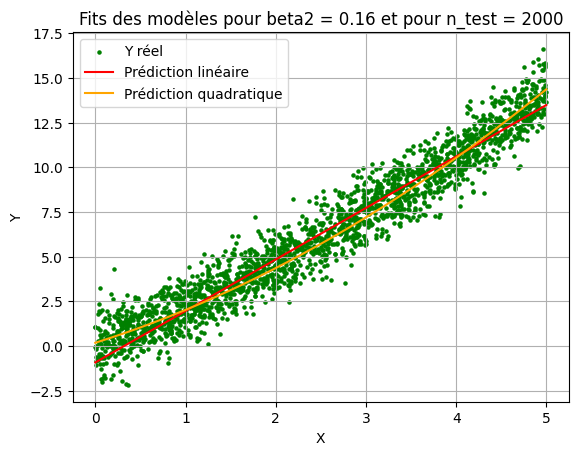

In [50]:
# Vérifier les fits de nos modèles

def print_training_test_sets():

      np.random.seed(42)
      epsilon = np.random.normal(0, 1, n + m)
      x = np.random.uniform(0, 5, n + m)

      x_train = x[:n]
      x_test = x[n:n+m]

      epsilon_train = epsilon[:n]
      epsilon_test = epsilon[n:n+m]

      for beta2 in beta2_values:

          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train
          y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

           # Linear Model : A
          model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
          y_pred_a = model_a.predict(x_test.reshape(-1, 1))
          pa = (y_test - y_pred_a)**2

          coef_a = model_a.coef_[0]
          intercept_a = model_a.intercept_

          # Quadratic Model : B
          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_b = LinearRegression().fit(x_train_quad, y_train)
          y_pred_b = model_b.predict(x_test_quad)
          pb = (y_test - y_pred_b)**2

          coef_b = model_b.coef_
          intercept_b = model_b.intercept_

          y = beta1*x + beta2*x**2 +epsilon
          eq_a = intercept_a + coef_a * x
          eq_b = intercept_b + coef_b[0] * x + coef_b[1] * x**2

          plt.figure() # Fits des modèles
          plt.title("Fits des modèles pour " f"beta2 = {beta2}" " et pour "f"n_test = {m}" )
          plt.scatter(x[np.argsort(x)], y[np.argsort(x)], label = "Y réel", color = "green", s = 5)
          plt.plot(x[np.argsort(x)], eq_a[np.argsort(x)], label = "Prédiction linéaire", color = "Red")
          plt.plot(x[np.argsort(x)], eq_b[np.argsort(x)], label = "Prédiction quadratique", color = "Orange")
          plt.xlabel("X")
          plt.ylabel("Y")
          plt.grid()
          plt.legend()
          plt.show()

print_training_test_sets()

### Descriptive statistics

- Provide descriptive statistics and graphs for the performance metrics on the test sample for the two models. For now, do this only for one (non-zero and sufficiently large) value of $\beta_2$.
  - For the graph, put on the same graph a jittered plot of the performance metric and a box plot with the median and the IQR.     
  - For descriptive statistics, report the empirical mean $m_A$, the empirical standard-deviation $s_A$, the median, and the IQR.

We first compute the errors conditionally to X.


## II - Erreurs de prédiction de chacun des modèles

In [51]:
# Performance des deux modèles conditionnellement à X

def performances_metrics_cond_X():

    for m in M:

        x = np.random.uniform(0, 5, n + m)
        x_train = x[:n]

        epsilon = np.random.normal(0, 1, n + m)
        epsilon_train = epsilon[:n]
        x_test = x[n:n + m]
        epsilon_test = epsilon[n:n + m]

        # for beta2 in beta2_values

        for beta2 in beta2_values:


            y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train
            y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

            # Linear Model : A
            model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
            y_pred_a = model_a.predict(x_test.reshape(-1, 1))
            pa = (y_test - y_pred_a)**2

            # Quadratic Model : B
            x_train_quad = np.column_stack((x_train, x_train**2))
            x_test_quad = np.column_stack((x_test, x_test**2))

            model_b = LinearRegression().fit(x_train_quad, y_train)
            y_pred_b = model_b.predict(x_test_quad)
            pb = (y_test - y_pred_b)**2

            differences = pa - pb

            # Représentation graphique de pa - pb, la différence de performance entre deux modèles
            plt.figure(figsize=(10, 6))
            plt.title(f"pa - pb  pour beta2 = {beta2} et pour n_test= {m}")

            sns.scatterplot(x=x_test, y=differences, color="red", s=6, label=f"Differences pour beta2 = {beta2} et pour n_test = {m}")
            plt.axhline(y=0, color='black', linestyle='--', label='y = 0')

            box = plt.boxplot(differences, positions=[max(x_test) + 1], widths=0.5, patch_artist=True,
                              boxprops=dict(facecolor='blue', color='blue', alpha=0.5),
                              medianprops=dict(color='yellow'),
                              whiskerprops=dict(color='blue'),
                              capprops=dict(color='blue'),
                              flierprops=dict(color='blue', markeredgecolor='blue'))

            whisker_min = box['whiskers'][0].get_ydata()[1]
            whisker_max = box['whiskers'][1].get_ydata()[1]
            q1 = box['boxes'][0].get_path().vertices[0, 1]
            median = box['medians'][0].get_ydata()[0]
            q3 = box['boxes'][0].get_path().vertices[2, 1]

            plt.text(max(x_test) + 1, whisker_min, f'Whisker Min: {whisker_min:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, whisker_max, f'Whisker Max: {whisker_max:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, q1, f'Q1: {q1:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, median, f'Median: {median:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, q3, f'Q3: {q3:.2f}', horizontalalignment='center', color='black')

            plt.xlabel("X test set")
            plt.ylabel("Differences")
            plt.grid()
            plt.legend()
            plt.show()

            # Représentation de pa, l'erreur du modèle linéaire

            plt.figure(figsize=(10, 6))
            plt.title(f"pa = (y-ya)**2  pour beta2 = {beta2} et pour n_test= {m}")

            sns.scatterplot(x=x_test, y=pa, color="red", s=6, label=f"Differences pour beta2 = {beta2} et pour n_test = {m}")

            box = plt.boxplot(pb, positions=[max(x_test) + 1], widths=0.5, patch_artist=True,
                              boxprops=dict(facecolor='blue', color='blue', alpha=0.5),
                              medianprops=dict(color='yellow'),
                              whiskerprops=dict(color='blue'),
                              capprops=dict(color='blue'),
                              flierprops=dict(color='blue', markeredgecolor='blue'))

            whisker_min = box['whiskers'][0].get_ydata()[1]
            whisker_max = box['whiskers'][1].get_ydata()[1]
            q1 = box['boxes'][0].get_path().vertices[0, 1]
            median = box['medians'][0].get_ydata()[0]
            q3 = box['boxes'][0].get_path().vertices[2, 1]

            plt.text(max(x_test) + 1, whisker_min, f'Whisker Min: {whisker_min:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, whisker_max, f'Whisker Max: {whisker_max:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, q1, f'Q1: {q1:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, median, f'Median: {median:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, q3, f'Q3: {q3:.2f}', horizontalalignment='center', color='black')

            plt.xlabel("X test set")
            plt.ylabel("pa = (y-ya)**2")
            plt.grid()
            plt.legend()
            plt.show()

            plt.figure(figsize=(10, 6))
            plt.title(f"pb = (y-yb)**2  pour beta2 = {beta2} et pour n_test= {m}")

            sns.scatterplot(x=x_test, y=pb, color="red", s=6, label=f"Differences pour beta2 = {beta2} et pour n_test = {m}")

            box = plt.boxplot(pb, positions=[max(x_test) + 1], widths=0.5, patch_artist=True,
                              boxprops=dict(facecolor='blue', color='blue', alpha=0.5),
                              medianprops=dict(color='yellow'),
                              whiskerprops=dict(color='blue'),
                              capprops=dict(color='blue'),
                              flierprops=dict(color='blue', markeredgecolor='blue'))

            whisker_min = box['whiskers'][0].get_ydata()[1]
            whisker_max = box['whiskers'][1].get_ydata()[1]
            q1 = box['boxes'][0].get_path().vertices[0, 1]
            median = box['medians'][0].get_ydata()[0]
            q3 = box['boxes'][0].get_path().vertices[2, 1]

            plt.text(max(x_test) + 1, whisker_min, f'Whisker Min: {whisker_min:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, whisker_max, f'Whisker Max: {whisker_max:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, q1, f'Q1: {q1:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, median, f'Median: {median:.2f}', horizontalalignment='center', color='black')
            plt.text(max(x_test) + 1, q3, f'Q3: {q3:.2f}', horizontalalignment='center', color='black')

            plt.xlabel("X test set")
            plt.ylabel("pb = (y-yb)**2")
            plt.grid()
            plt.legend()
            plt.show()

Then we look at the distribution of performance for each model

In [52]:
# Répartition de la performance du modèle

def performance_metrics_hist():

    for m in M:

      np.random.seed(42)
      beta1 = 2
      epsilon = np.random.normal(0, 1, n + m)
      x = np.random.uniform(0, 5, n + m)

      x_train = x[:n]
      x_test = x[n:n+m]

      epsilon_train = epsilon[:n]
      epsilon_test = epsilon[n:n+m]

      for beta2 in beta2_values:


          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train
          y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

           # Linear Model : A
          model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
          y_pred_a = model_a.predict(x_test.reshape(-1, 1))
          pa = (y_test - y_pred_a)**2

          # Quadratic Model : B
          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_b = LinearRegression().fit(x_train_quad, y_train)
          y_pred_b = model_b.predict(x_test_quad)
          pb = (y_test - y_pred_b)**2

          differences = pa - pb

          plt.figure() # Erreur individuelle des modèles
          plt.title("prédiction du modèle linéaire pour " f"beta2 = {beta2}" " et pour "f"n_test = {m}" )
          plt.hist(pa, bins=30, label=f"pa = (y - ya)^2 pour beta2 = {beta2} et pour n_test = {m}", color="red", edgecolor='black', alpha=0.7)
          plt.xlabel(" Erreur associée ")
          plt.ylabel("Nombre d'occurences")
          plt.grid()
          plt.legend()
          plt.show()

          plt.figure()
          plt.title("prédiction du modèle quadratique pour " f"beta2 = {beta2}" " et pour "f"n_test = {m}" )
          plt.hist(pb, bins=30, label=f"pb = (y - yb)^2 pour beta2 = {beta2} et pour n_test = {m}", color="orange", edgecolor='black', alpha=0.7)
          plt.xlabel(" Erreur associée ")
          plt.ylabel("Nombre d'occurences")
          plt.grid()
          plt.legend()
          plt.show()

          plt.figure()
          plt.title("Différence de prédiction des modèles " f"beta2 = {beta2}" " et pour "f"n_test = {m}" )
          plt.hist(differences, bins=30, label=f"pa - pb pour beta2 = {beta2} et pour n_test = {m}", color="blue", edgecolor='black', alpha=0.7)
          plt.xlabel(" Erreur associée ")
          plt.ylabel("Nombre d'occurences")
          plt.grid()
          plt.legend()
          plt.show()

And finally a short look at MSE

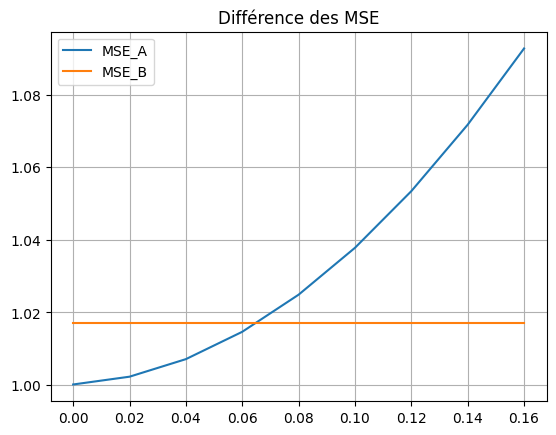

In [53]:
# MSE

def MSE():

    epsilon = np.random.normal(0, 1, n + m)
    x = np.random.uniform(0, 5, n + m)

    x_train = x[:n]
    x_test = x[n:n+m]

    epsilon_train = epsilon[:n]
    epsilon_test = epsilon[n:n+m]

    mse_A = []
    mse_B = []

    for beta2 in beta2_values:

        y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train
        y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

         # Linear Model : A
        model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
        y_pred_a = model_a.predict(x_test.reshape(-1, 1))

        mse_A.append(mean_squared_error(y_pred_a, y_test))

          # Quadratic Model : B
        x_train_quad = np.column_stack((x_train, x_train**2))
        x_test_quad = np.column_stack((x_test, x_test**2))

        model_b = LinearRegression().fit(x_train_quad, y_train)
        y_pred_b = model_b.predict(x_test_quad)
        mse_B.append(mean_squared_error(y_pred_b, y_test))

    plt.figure()
    plt.title("Différence des MSE")
    plt.plot(beta2_values, mse_A, label = "MSE_A")
    plt.plot(beta2_values, mse_B, label = "MSE_B")

    plt.grid()
    plt.legend()
    plt.show()

MSE()

## III - Statistiques descriptives sur l'erreur de prédiction de chacun des modèles

In [54]:
# Création d'un tableau regroupant différents indicateurs

def descriptive_statistics():

    empirical_means_A = []
    standard_deviations_A = []
    medians_A = []
    Q1_A = []
    Q3_A = []
    IQR_A = []

    empirical_means_B = []
    standard_deviations_B = []
    medians_B = []
    Q1_B = []
    Q3_B = []
    IQR_B = []

    for m in M:

      a = []
      b = []
      c = []
      d = []
      q = []
      iqr = []

      e = []
      f = []
      g = []
      h = []
      q_ = []
      iqr_ = []

      epsilon = np.random.normal(0, 1, n + m)
      x = np.random.uniform(0, 5, n + m)

      x_train = x[:n]
      x_test = x[n:n+m]

      epsilon_train = epsilon[:n]
      epsilon_test = epsilon[n:n+m]

      for beta2 in beta2_values:

          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train
          y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

        # Linear Model : A
          model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
          y_pred_a = model_a.predict(x_test.reshape(-1, 1))
          pa = (y_test - y_pred_a)**2

        # Quadratic Model : B
          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_b = LinearRegression().fit(x_train_quad, y_train)
          y_pred_b = model_b.predict(x_test_quad)
          pb = (y_test - y_pred_b)**2

          mean_a = sum(pa)/m
          mean_b = sum(pb)/m

          a.append(mean_a)
          e.append(mean_b)

          std_a = np.std(pa, ddof=1)
          std_b = np.std(pb, ddof = 1)

          b.append(std_a)
          f.append(std_b)

          q1_a = np.percentile(pa, 25)
          med_a = np.percentile(pa, 50)
          q3_a = np.percentile(pa, 75)

          q1_b = np.percentile(pb, 25)
          med_b = np.percentile(pb, 50)
          q3_b = np.percentile(pb, 75)

          c.append(med_a)
          g.append(med_b)
          d.append(q1_a)
          q.append(q3_a)
          h.append(q1_b)
          q_.append(q3_b)

          iqr.append(q3_a - q1_a)
          iqr_.append(q3_b - q1_b)

      empirical_means_A.append(a)
      empirical_means_B.append(e)
      standard_deviations_A.append(b)
      standard_deviations_B.append(f)
      medians_A.append(c)
      medians_B.append(g)
      Q1_A.append(d)
      Q1_B.append(h)
      Q3_A.append(q)
      Q3_B.append(q_)
      IQR_A.append(iqr)
      IQR_B.append(iqr_)

    return empirical_means_A, standard_deviations_A, medians_A, Q1_A, Q3_A, IQR_A, empirical_means_B, standard_deviations_B, medians_B, Q1_B, Q3_B, IQR_B

def create_data():

    empirical_means_A, standard_deviations_A, medians_A, Q1_A, Q3_A, IQR_A, empirical_means_B, standard_deviations_B, medians_B, Q1_B, Q3_B, IQR_B = descriptive_statistics()


    data_A_all = {
    "Empirical Mean": empirical_means_A,
    "Standard Deviation": standard_deviations_A,
    "Median": medians_A,
    "Q1": Q1_A,
    "Q3": Q3_A,
    "IQR": IQR_A
   }

    stats_A_all = pd.DataFrame(data_A_all, index=M)

    data_B_all = {
    "Empirical Mean": empirical_means_B,
    "Standard Deviation": standard_deviations_B,
    "Median": medians_B,
    "Q1": Q1_B,
    "Q3": Q3_B,
    "IQR": IQR_B
   }

    stats_B_all = pd.DataFrame(data_B_all, index=M)

    df_empirical_means_A = pd.DataFrame(empirical_means_A, index=M, columns=beta2_values).transpose()
    df_empirical_standard_deviations_A = pd.DataFrame(standard_deviations_A, index=M, columns=beta2_values).transpose()
    df_medians_A = pd.DataFrame(medians_A, index=M, columns=beta2_values).transpose()
    df_Q1_A = pd.DataFrame(Q1_A, index=M, columns=beta2_values).transpose()
    df_Q3_A = pd.DataFrame(Q3_A, index=M, columns=beta2_values).transpose()
    df_IQR_A = pd.DataFrame(IQR_A, index=M, columns=beta2_values).transpose()

    df_empirical_means_B = pd.DataFrame(empirical_means_B, index=M, columns=beta2_values).transpose()
    df_empirical_standard_deviations_B = pd.DataFrame(standard_deviations_B, index=M, columns=beta2_values).transpose()
    df_medians_B = pd.DataFrame(medians_B, index=M, columns=beta2_values).transpose()
    df_Q1_B = pd.DataFrame(Q1_B, index=M, columns=beta2_values).transpose()
    df_Q3_B = pd.DataFrame(Q3_B, index=M, columns=beta2_values).transpose()
    df_IQR_B = pd.DataFrame(IQR_B, index=M, columns=beta2_values).transpose()

    return stats_A_all, df_empirical_means_A, df_empirical_standard_deviations_A, df_medians_A, df_Q1_A, df_Q3_A, df_IQR_A, \
    stats_B_all, df_empirical_means_B, df_empirical_standard_deviations_B, df_medians_B, df_Q1_B, df_Q3_B, df_IQR_B


(stats_A_all, df_empirical_means_A, df_empirical_standard_deviations_A, df_medians_A, df_Q1_A, df_Q3_A, df_IQR_A,
    stats_B_all, df_empirical_means_B, df_empirical_standard_deviations_B, df_medians_B, df_Q1_B, df_Q3_B, df_IQR_B) = create_data()

We first compute the evolutions of some variables such at the quartile of errors for models or the standard deviation for varying beta2 between 0 and 0.16.

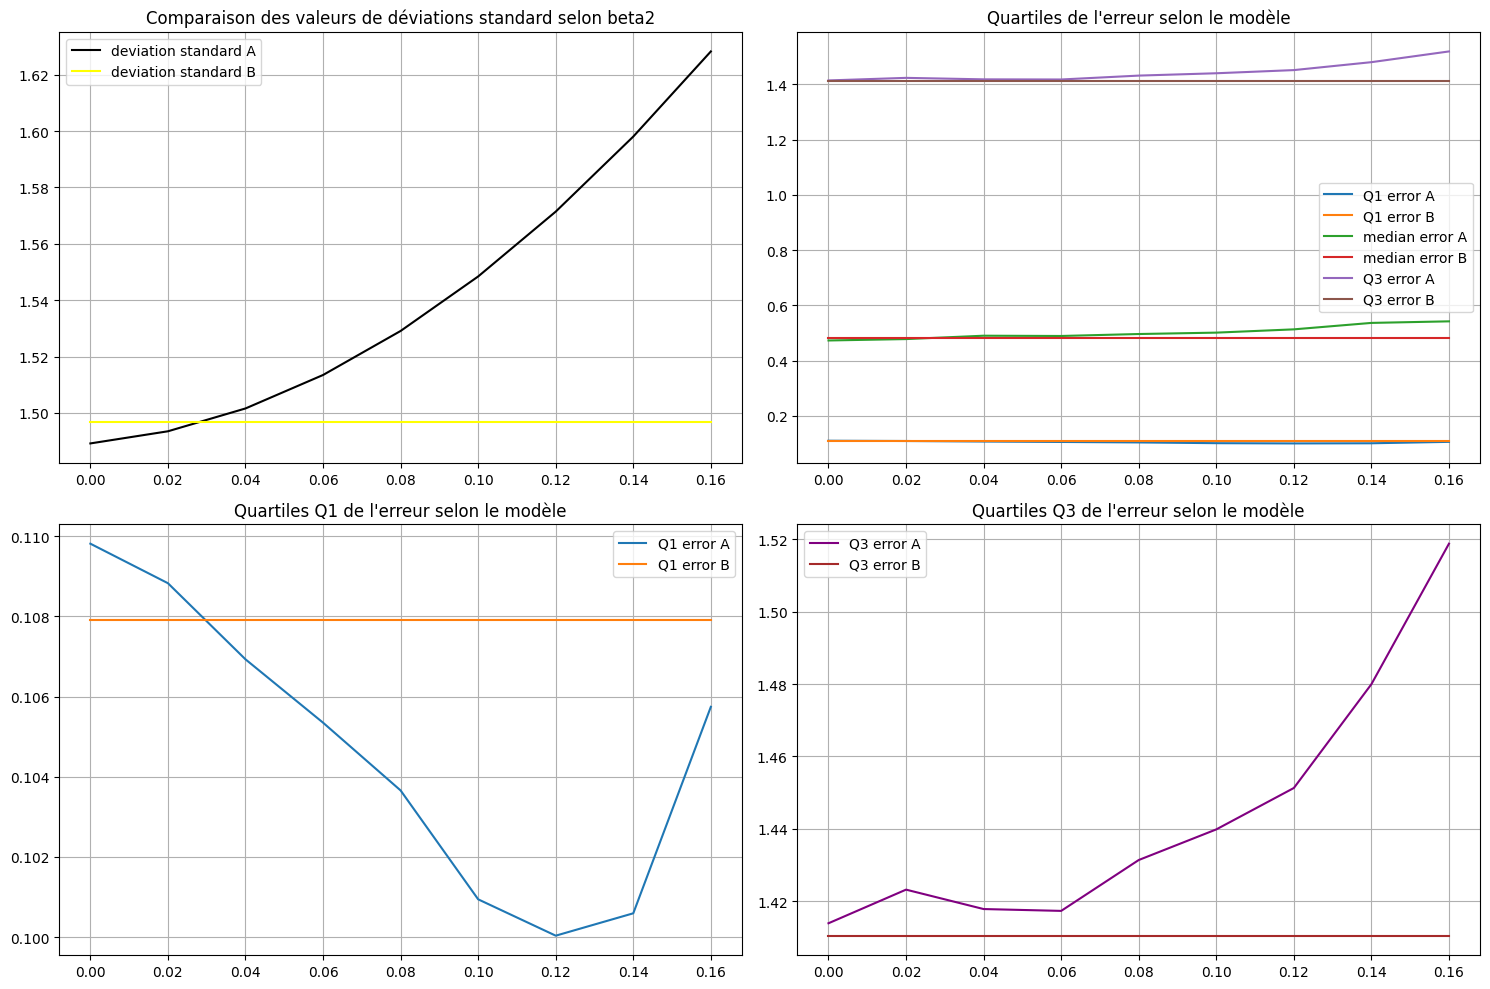

In [55]:
# Comparaison de certaines variables selon beta2

def plot_variables_beta2():

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].plot(beta2_values, df_empirical_standard_deviations_A[2000], label="deviation standard A", color="black")
    axs[0, 0].plot(beta2_values, df_empirical_standard_deviations_B[2000], label="deviation standard B", color="yellow")
    axs[0, 0].set_title("Comparaison des valeurs de déviations standard selon beta2")
    axs[0, 0].grid()
    axs[0, 0].legend()

    axs[0, 1].plot(beta2_values, df_Q1_A[2000], label="Q1 error A")
    axs[0, 1].plot(beta2_values, df_Q1_B[2000], label="Q1 error B")
    axs[0, 1].plot(beta2_values, df_medians_A[2000], label="median error A")
    axs[0, 1].plot(beta2_values, df_medians_B[2000], label="median error B")
    axs[0, 1].plot(beta2_values, df_Q3_A[2000], label="Q3 error A")
    axs[0, 1].plot(beta2_values, df_Q3_B[2000], label="Q3 error B")
    axs[0, 1].set_title("Quartiles de l'erreur selon le modèle")
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(beta2_values, df_Q1_A[2000], label="Q1 error A")
    axs[1, 0].plot(beta2_values, df_Q1_B[2000], label="Q1 error B")
    axs[1, 0].set_title("Quartiles Q1 de l'erreur selon le modèle")
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(beta2_values, df_Q3_A[2000], label="Q3 error A", color="purple")
    axs[1, 1].plot(beta2_values, df_Q3_B[2000], label="Q3 error B", color="brown")
    axs[1, 1].set_title("Quartiles Q3 de l'erreur selon le modèle")
    axs[1, 1].grid()
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()
plot_variables_beta2()

Then, we fix 3 values for beta2, 0, 0.08 and 0.16, and we analyse the behaviour of our variables with increasing size of test sample n\_test

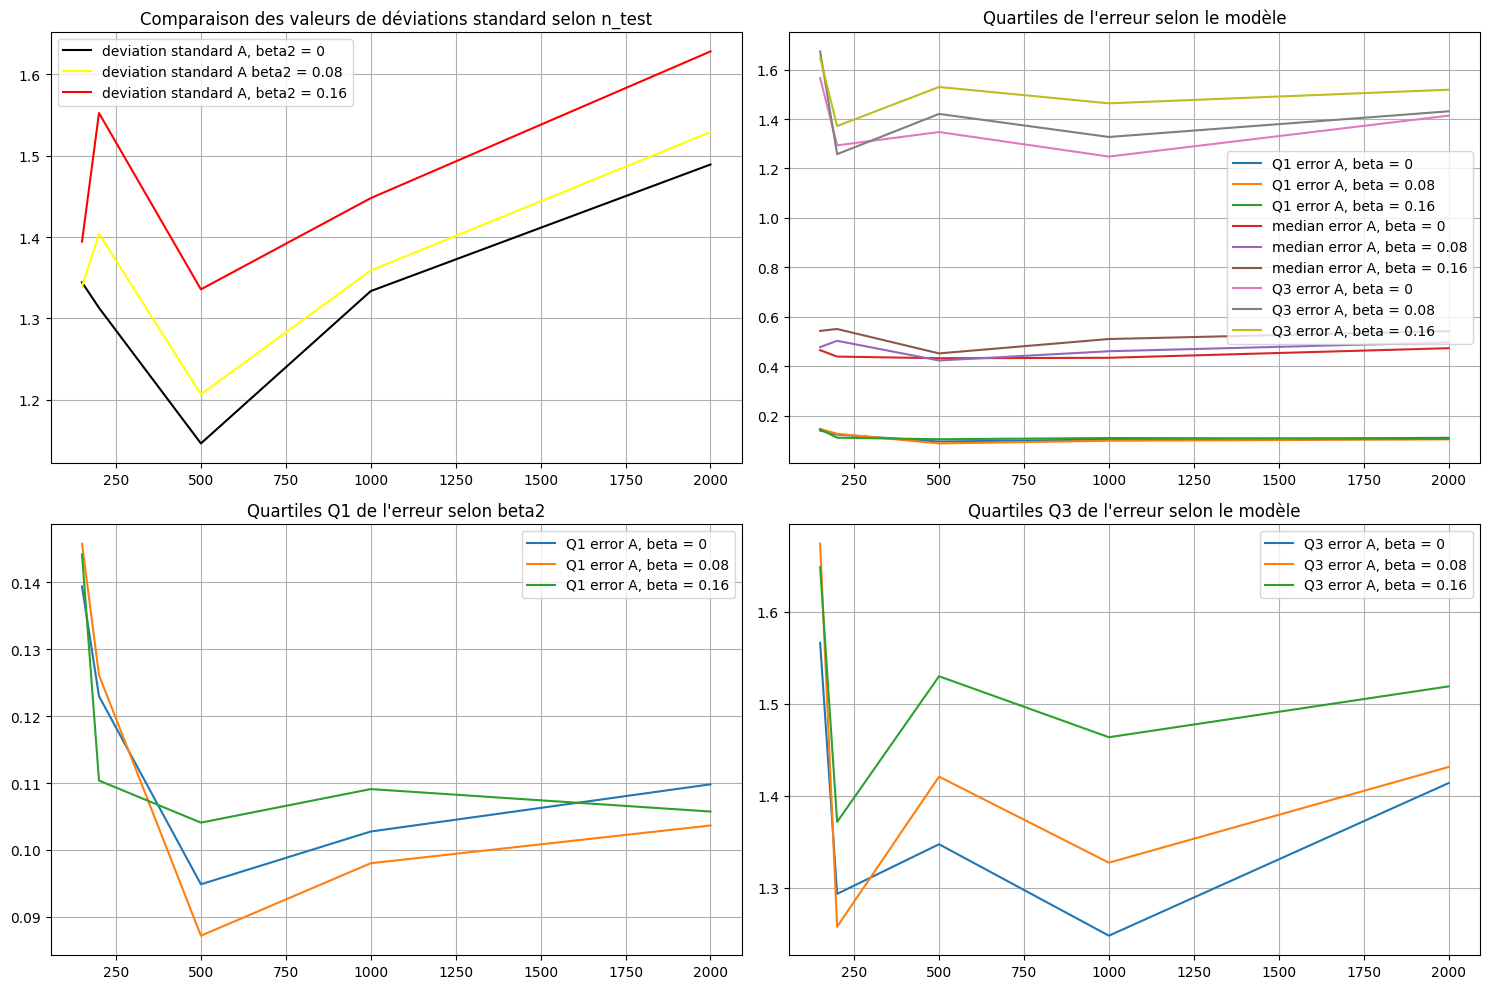

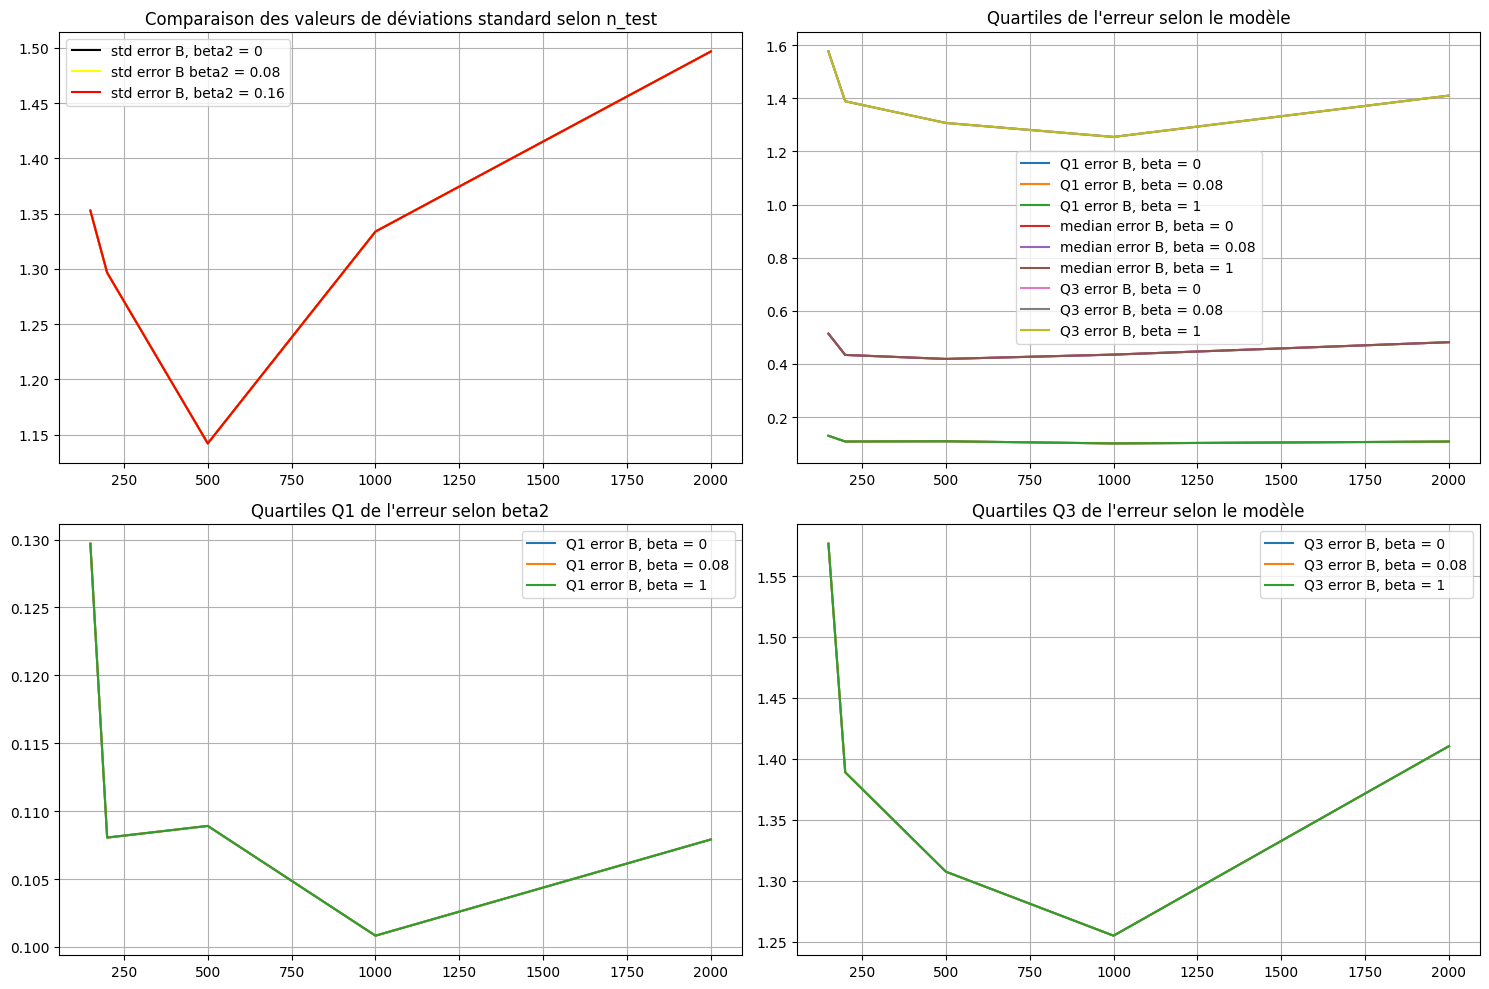

In [56]:
# Comparaison de certaines variables selon n_test

def plot_variables_ntest():

    beta2_1, beta2_2, beta2_3 = [0.0, 0.08, 0.16]

    df1_std = df_empirical_standard_deviations_A.loc[beta2_1]
    df2_std = df_empirical_standard_deviations_A.loc[beta2_2]
    df3_std = df_empirical_standard_deviations_A.loc[beta2_3]

    df1_med = df_medians_A.loc[beta2_1]
    df2_med = df_medians_A.loc[beta2_2]
    df3_med = df_medians_A.loc[beta2_3]

    df1_q1 = df_Q1_A.loc[beta2_1]
    df2_q1 = df_Q1_A.loc[beta2_2]
    df3_q1 = df_Q1_A.loc[beta2_3]

    df1_q3 = df_Q3_A.loc[beta2_1]
    df2_q3 = df_Q3_A.loc[beta2_2]
    df3_q3 = df_Q3_A.loc[beta2_3]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Premier subplot : Comparaison des valeurs de deviations standard selon beta2
    axs[0, 0].plot(M, df1_std, label="deviation standard A, beta2 = 0", color="black")
    axs[0, 0].plot(M, df2_std, label="deviation standard A beta2 = 0.08", color="yellow")
    axs[0, 0].plot(M, df3_std, label="deviation standard A, beta2 = 0.16", color="red")
    axs[0, 0].set_title("Comparaison des valeurs de déviations standard selon n_test")
    axs[0, 0].grid()
    axs[0, 0].legend()

    # Deuxième subplot : Quartiles de l'erreur selon le modèle
    axs[0, 1].plot(M, df1_q1, label="Q1 error A, beta = 0")
    axs[0, 1].plot(M, df2_q1, label="Q1 error A, beta = 0.08")
    axs[0, 1].plot(M, df3_q1, label="Q1 error A, beta = 0.16")
    axs[0, 1].plot(M, df1_med, label="median error A, beta = 0")
    axs[0, 1].plot(M, df2_med, label="median error A, beta = 0.08")
    axs[0, 1].plot(M, df3_med, label="median error A, beta = 0.16")
    axs[0, 1].plot(M, df1_q3, label="Q3 error A, beta = 0")
    axs[0, 1].plot(M, df2_q3, label="Q3 error A, beta = 0.08")
    axs[0, 1].plot(M, df3_q3, label="Q3 error A, beta = 0.16")
    axs[0, 1].set_title("Quartiles de l'erreur selon le modèle")
    axs[0, 1].grid()
    axs[0, 1].legend()

    axs[1, 0].plot(M, df1_q1, label="Q1 error A, beta = 0")
    axs[1, 0].plot(M, df2_q1, label="Q1 error A, beta = 0.08")
    axs[1, 0].plot(M, df3_q1, label="Q1 error A, beta = 0.16")
    axs[1, 0].set_title("Quartiles Q1 de l'erreur selon beta2")
    axs[1, 0].grid()
    axs[1, 0].legend()

    axs[1, 1].plot(M, df1_q3, label="Q3 error A, beta = 0")
    axs[1, 1].plot(M, df2_q3, label="Q3 error A, beta = 0.08")
    axs[1, 1].plot(M, df3_q3, label="Q3 error A, beta = 0.16")
    axs[1, 1].set_title("Quartiles Q3 de l'erreur selon le modèle")
    axs[1, 1].grid()
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    df1_std = df_empirical_standard_deviations_B.loc[beta2_1]
    df2_std = df_empirical_standard_deviations_B.loc[beta2_2]
    df3_std = df_empirical_standard_deviations_B.loc[beta2_3]

    df1_med = df_medians_B.loc[beta2_1]
    df2_med = df_medians_B.loc[beta2_2]
    df3_med = df_medians_B.loc[beta2_3]

    df1_q1 = df_Q1_B.loc[beta2_1]
    df2_q1 = df_Q1_B.loc[beta2_2]
    df3_q1 = df_Q1_B.loc[beta2_3]

    df1_q3 = df_Q3_B.loc[beta2_1]
    df2_q3 = df_Q3_B.loc[beta2_2]
    df3_q3 = df_Q3_B.loc[beta2_3]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Premier subplot : Comparaison des valeurs de deviations standard selon beta2
    axs[0, 0].plot(M, df1_std, label="std error B, beta2 = 0", color="black")
    axs[0, 0].plot(M, df2_std, label="std error B beta2 = 0.08", color="yellow")
    axs[0, 0].plot(M, df3_std, label="std error B, beta2 = 0.16", color="red")
    axs[0, 0].set_title("Comparaison des valeurs de déviations standard selon n_test")
    axs[0, 0].grid()
    axs[0, 0].legend()

    # Deuxième subplot : Quartiles de l'erreur selon le modèle
    axs[0, 1].plot(M, df1_q1, label="Q1 error B, beta = 0")
    axs[0, 1].plot(M, df2_q1, label="Q1 error B, beta = 0.08")
    axs[0, 1].plot(M, df3_q1, label="Q1 error B, beta = 1")
    axs[0, 1].plot(M, df1_med, label="median error B, beta = 0")
    axs[0, 1].plot(M, df2_med, label="median error B, beta = 0.08")
    axs[0, 1].plot(M, df3_med, label="median error B, beta = 1")
    axs[0, 1].plot(M, df1_q3, label="Q3 error B, beta = 0")
    axs[0, 1].plot(M, df2_q3, label="Q3 error B, beta = 0.08")
    axs[0, 1].plot(M, df3_q3, label="Q3 error B, beta = 1")
    axs[0, 1].set_title("Quartiles de l'erreur selon le modèle")
    axs[0, 1].grid()
    axs[0, 1].legend()

    # Troisième subplot : Quartiles Q1 de l'erreur selon le modèle
    axs[1, 0].plot(M, df1_q1, label="Q1 error B, beta = 0")
    axs[1, 0].plot(M, df2_q1, label="Q1 error B, beta = 0.08")
    axs[1, 0].plot(M, df3_q1, label="Q1 error B, beta = 1")
    axs[1, 0].set_title("Quartiles Q1 de l'erreur selon beta2")
    axs[1, 0].grid()
    axs[1, 0].legend()

    # Quatrième subplot : Quartiles Q3 de l'erreur selon le modèle
    axs[1, 1].plot(M, df1_q3, label="Q3 error B, beta = 0")
    axs[1, 1].plot(M, df2_q3, label="Q3 error B, beta = 0.08")
    axs[1, 1].plot(M, df3_q3, label="Q3 error B, beta = 1")
    axs[1, 1].set_title("Quartiles Q3 de l'erreur selon le modèle")
    axs[1, 1].grid()
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

plot_variables_ntest()

## IV - Inferential statistics


- How precise is the estimation of $\mu_A$ by the empirical mean $m_A$ (same for model $B$)?
  - Standard error of the mean
    - Derive formulas (or algorithms) for the standard error (SE) of the mean
      - Methods: parametric estimates, bootstrap estimates
    - Compute the standard error for different subsets of the testing set of increasing size $k\leq n$ using both the derived formula and a bootstrap estimate (where the bootstrap is used to simulate the sampling distribution of the mean and the standard error is thus the standard deviation of this sampling distribution)
  - Confidence interval
    - Derive formulas (or algorithms) for confidence interval of the mean
      - Methods: using standard-error computed above (consider different cases when $n$ is small versus large and when $V_A$ is assumed to be Gaussian or not), using bootstrap


### IV.1 - Parametric estimates

### IV..A - When n_test is large

# Erreur Standard de la Moyenne

L'erreur standard de la moyenne $$SE(\overline{d})$$ est une mesure de la dispersion de la moyenne d'un échantillon par rapport à la vraie moyenne de la population. Elle est calculée en utilisant l'écart type empirique (s) divisé par la racine carrée de la taille de l'échantillon de test (n\_test).

Lorsque n\_test est grand, il vient du Théorème Centrale Limite la formule suivante :

$$
SE(\overline{d}) = \frac{s}{\sqrt{n\_test}}
$$

où :
- \( s \) est l'écart type empirique de l'échantillon,
- \( n_test \) est la taille de l'échantillon de test.

Cette formule permet de comprendre à quel point la moyenne de l'échantillon est susceptible de varier par rapport à la moyenne réelle de la population. Plus la taille de l'échantillon est grande, plus l'erreur standard de la moyenne est petite, indiquant une estimation plus précise de la moyenne de la population. On parle d'estimation paramétrique


In [57]:
# Estimation paramétrique de l'erreur standard

def divide_by_sqrt(df):
    return df.apply(lambda x: x / np.sqrt(x.name), axis=0)

def standard_error_test_large():

    (stats_A_all, df_empirical_means_A, df_empirical_standard_deviations_A, df_medians_A, df_Q1_A, df_Q3_A, df_IQR_A,
    stats_B_all, df_empirical_means_B, df_empirical_standard_deviations_B, df_medians_B, df_Q1_B, df_Q3_B, df_IQR_B) = create_data()

    df_standard_error_A = divide_by_sqrt(df_empirical_standard_deviations_A)
    df_standard_error_B = divide_by_sqrt(df_empirical_standard_deviations_B)

    return df_standard_error_A, df_standard_error_B


df_standard_error_A, df_standard_error_B = standard_error_test_large()

### IV.1.B - When n_test is small

### IV.1.C - When n_test is small and not gaussian

### IV.2 -  Non parametric estimates / Bootstrap estimates

### IV.2.A - Bootstrap on test sample

In [58]:
# Détermination de l'erreur standard par bootstrapping

def standard_error_bootstrap_test():

   B = 250

   se_bootstrap_A = []
   se_bootstrap_B = []

   for m in M:

      liste_A = []
      liste_B = []
      beta1 = 2
      epsilon = np.random.normal(0, 1, n + m)
      x = np.random.uniform(0, 5, n + m)

      x_train = x[:n]
      epsilon_train = epsilon[:n]
      x_train_quad = np.column_stack((x_train, x_train**2))
      bootstrap_indices = np.random.choice(m, size=(B, m), replace=True)

      for beta2 in beta2_values:

            liste_boot_A = []
            liste_boot_B = []
            y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train

            for bootstrap_index in bootstrap_indices:

               x_test = x[bootstrap_index]
               y_test = beta1 * x_test + beta2 * x_test**2 + epsilon[bootstrap_index]

               model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
               y_pred_a = model_a.predict(x_test.reshape(-1, 1))
               pa = (y_test - y_pred_a)**2


               x_test_quad = np.column_stack((x_test, x_test**2))
               model_b = LinearRegression().fit(x_train_quad, y_train)
               y_pred_b = model_b.predict(x_test_quad)
               pb = (y_test - y_pred_b)**2

               mean_A = np.mean(pa)
               mean_B = np.mean(pb)

               liste_boot_A.append(mean_A)
               liste_boot_B.append(mean_B)

            liste_A.append(np.std(liste_boot_A))
            liste_B.append(np.std(liste_boot_B))

      se_bootstrap_A.append(liste_A)
      se_bootstrap_B.append(liste_B)

   df_se_bootstrap_A = pd.DataFrame(se_bootstrap_A, index=M, columns=beta2_values).transpose()
   df_se_bootstrap_B = pd.DataFrame(se_bootstrap_B, index=M, columns=beta2_values).transpose()

   return df_se_bootstrap_A, df_se_bootstrap_B

### IV.2.B - Subsets of training sets (varying k)

In [59]:
# We pick subsets
# instead of growing the test size, we first generate the maximum test size and we use subsets of size k < m for testing

def standard_error_varying_test_derived():

    standard_errors_A = []
    standard_errors_B = []

    epsilon = np.random.normal(0, 1, n + m)
    x = np.random.uniform(0, 5, n + m)

    for k in M:

      x_train = x[:n]
      x_test = x[n:n+k]

      epsilon_train = epsilon[:n]
      epsilon_test = epsilon[n:n+k]

      liste_A = []
      liste_B = []

      for beta2 in beta2_values:

          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train
          y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

        # Linear Model : A
          model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
          y_pred_a = model_a.predict(x_test.reshape(-1, 1))
          pa = (y_test - y_pred_a)**2

        # Quadratic Model : B
          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_b = LinearRegression().fit(x_train_quad, y_train)
          y_pred_b = model_b.predict(x_test_quad)
          pb = (y_test - y_pred_b)**2

          se_a = np.std(pa, ddof=1)/(k**0.5)
          se_b = np.std(pb, ddof = 1)/(k**0.5)

          liste_A.append(se_a)
          liste_B.append(se_b)

      standard_errors_A.append(liste_A)
      standard_errors_B.append(liste_B)

    df_se_varying_k_A = pd.DataFrame(standard_errors_A, index=M, columns=beta2_values).transpose()
    df_se_varying_k_B = pd.DataFrame(standard_errors_B, index=M, columns=beta2_values).transpose()

    return df_se_varying_k_A, df_se_varying_k_B

### IV.2.C - Varying k & Bootstrap

In [60]:
# We use this new method and we bootstrap

def standard_error_varying_bootstrapped_test():

   B = 250

   se_bootstrap_A = []
   se_bootstrap_B = []

   for k in M:

      liste_A = []
      liste_B = []
      beta1 = 2
      epsilon = np.random.normal(0, 1, n + m)
      x = np.random.uniform(0, 5, n + m)

      x_train = x[:n]
      x_test = x[n:n+k]

      epsilon_train = epsilon[:n]
      epsilon_test = epsilon[n:n+k]

      x_train_quad = np.column_stack((x_train, x_train**2))

      bootstrap_indices = np.random.choice(k, size=(B, k), replace=True)

      for beta2 in beta2_values:

            liste_boot_A = []
            liste_boot_B = []
            y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train

            for bootstrap_index in bootstrap_indices:

               x_test = x[bootstrap_index]
               y_test = beta1 * x_test + beta2 * x_test**2 + epsilon[bootstrap_index]

               model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
               y_pred_a = model_a.predict(x_test.reshape(-1, 1))
               pa = (y_test - y_pred_a)**2


               x_test_quad = np.column_stack((x_test, x_test**2))
               model_b = LinearRegression().fit(x_train_quad, y_train)
               y_pred_b = model_b.predict(x_test_quad)
               pb = (y_test - y_pred_b)**2

               liste_boot_A.append(np.mean(pa))
               liste_boot_B.append(np.mean(pb))

            liste_A.append(np.std(liste_boot_A))
            liste_B.append(np.std(liste_boot_B))

      se_bootstrap_A.append(liste_A)
      se_bootstrap_B.append(liste_B)

   df_se_bootstrap_A = pd.DataFrame(se_bootstrap_A, index=M, columns=beta2_values).transpose()
   df_se_bootstrap_B = pd.DataFrame(se_bootstrap_B, index=M, columns=beta2_values).transpose()

   return df_se_bootstrap_A, df_se_bootstrap_B

### IV.3 - Comparison between various methods

### IV.3.A - Comparison between parametric method and bootstrap estimate

In [61]:
# Selection des valeurs de beta2

beta2_1 = 0.0
beta2_2 = 0.08
beta2_3 = 0.16


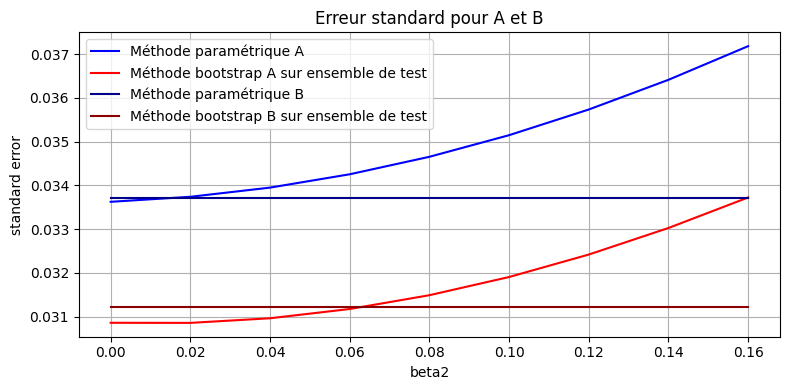

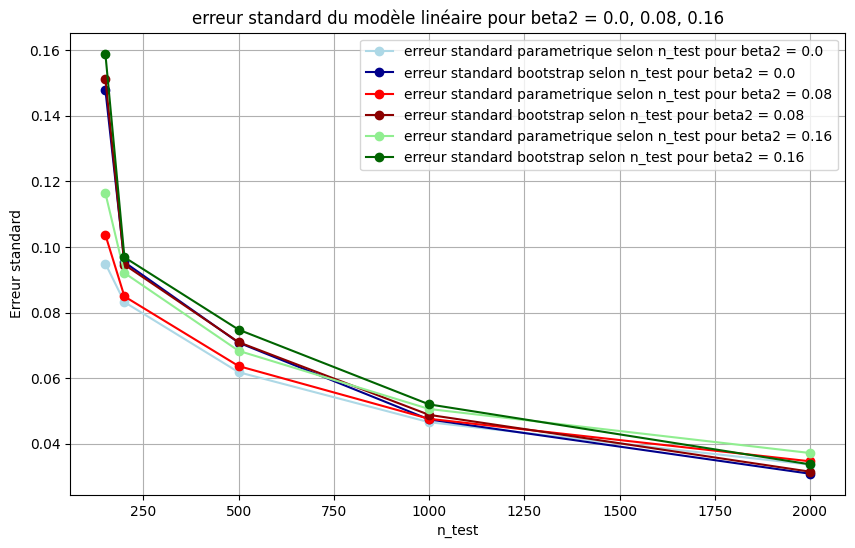

In [62]:
# Standard error obtained by parametric method against bootstrapped
def plot_standard_error_comparison():

    df_standard_error_A, df_standard_error_B = standard_error_test_large()
    df_se_bootstrap_A_test, df_se_bootstrap_B_test = standard_error_bootstrap_test()


    fig2, ax2 = plt.subplots(figsize=(8, 4))
    ax2.plot(beta2_values, df_standard_error_A[2000], label="Méthode paramétrique A", color="blue")
    ax2.plot(beta2_values, df_se_bootstrap_A_test[2000], label="Méthode bootstrap A sur ensemble de test", color="red")
    ax2.plot(beta2_values, df_standard_error_B[2000], label="Méthode paramétrique B", color="darkblue")
    ax2.plot(beta2_values, df_se_bootstrap_B_test[2000], label="Méthode bootstrap B sur ensemble de test", color="darkred")
    ax2.set_xlabel("beta2")
    ax2.set_ylabel("standard error")
    ax2.set_title("Erreur standard pour A et B")
    ax2.grid()
    ax2.legend()
    plt.tight_layout()
    plt.show()

    # Plot standard error for specific beta2 values
    df1 = df_standard_error_A.loc[beta2_1]
    df2 = df_standard_error_A.loc[beta2_2]
    df3 = df_standard_error_A.loc[beta2_3]
    df4 = df_se_bootstrap_A_test.loc[beta2_1]
    df5 = df_se_bootstrap_A_test.loc[beta2_2]
    df6 = df_se_bootstrap_A_test.loc[beta2_3]

    plt.figure(figsize=(10, 6))
    plt.plot(df1.index, df1.values, marker='o', label = "erreur standard parametrique selon n_test pour beta2 = "  f'{beta2_1}', color = "lightblue")
    plt.plot(df4.index, df4.values, marker='o', label = "erreur standard bootstrap selon n_test pour beta2 = " f'{beta2_1}', color = "darkblue")
    plt.plot(df2.index, df2.values, marker='o', label = "erreur standard parametrique selon n_test pour beta2 = " f'{beta2_2}', color = "red")
    plt.plot(df5.index, df5.values, marker='o', label = "erreur standard bootstrap selon n_test pour beta2 = " f'{beta2_2}', color = "darkred")
    plt.plot(df3.index, df3.values, marker='o', label = "erreur standard parametrique selon n_test pour beta2 = " f'{beta2_3}', color = "lightgreen")
    plt.plot(df6.index, df6.values, marker='o', label = "erreur standard bootstrap selon n_test pour beta2 = " f'{beta2_3}', color = "darkgreen")
    plt.xlabel("n_test")
    plt.title(f'erreur standard du modèle linéaire pour beta2 = {beta2_1}, {beta2_2}, {beta2_3}')
    plt.ylabel('Erreur standard')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_standard_error_comparison()


### IV.3.B - For varying k, comparison between bootstrapped method and parametric method

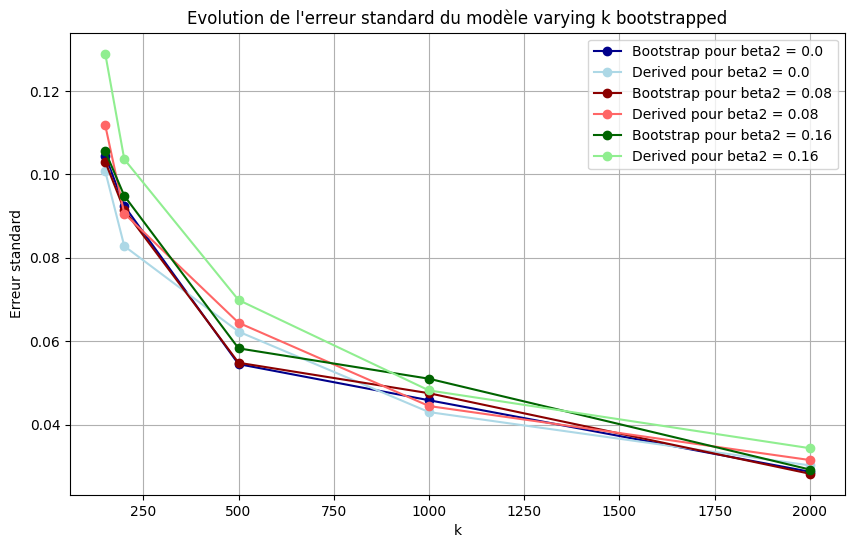

In [63]:
# Standard error obtained by parametric method against bootstrapped, varying method

def plot_standard_error_comparison_varying():


    df_se_varying_k_A, df_se_varying_k_B = standard_error_varying_test_derived()
    df_se_varying_bootstrap_A_test, df_se_varying_bootstrap_B_test = standard_error_varying_bootstrapped_test()

    df1 = df_se_varying_bootstrap_A_test.loc[beta2_1]
    df2 = df_se_varying_bootstrap_A_test.loc[beta2_2]
    df3 = df_se_varying_bootstrap_A_test.loc[beta2_3]
    df4 = df_se_varying_k_A.loc[beta2_1]
    df5 = df_se_varying_k_A.loc[beta2_2]
    df6 = df_se_varying_k_A.loc[beta2_3]

    plt.figure(figsize=(10, 6))
    plt.plot(df1.index, df1.values, marker='o', label=f"Bootstrap pour beta2 = {beta2_1}", color="darkblue")
    plt.plot(df1.index, df4.values, marker='o', label=f"Derived pour beta2 = {beta2_1}", color="lightblue")
    plt.plot(df2.index, df2.values, marker='o', label=f"Bootstrap pour beta2 = {beta2_2}", color="darkred")
    plt.plot(df2.index, df5.values, marker='o', label=f"Derived pour beta2 = {beta2_2}", color="#FF6666")
    plt.plot(df3.index, df3.values, marker='o', label=f"Bootstrap pour beta2 = {beta2_3}", color="darkgreen")
    plt.plot(df3.index, df6.values, marker='o', label=f"Derived pour beta2 = {beta2_3}", color="lightgreen")
    plt.title('Evolution de l\'erreur standard du modèle varying k bootstrapped')
    plt.xlabel('k')
    plt.ylabel('Erreur standard')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_standard_error_comparison_varying()


### IV.3.C - Comparison between varying test samples (k < m) and varying test size (k =m)

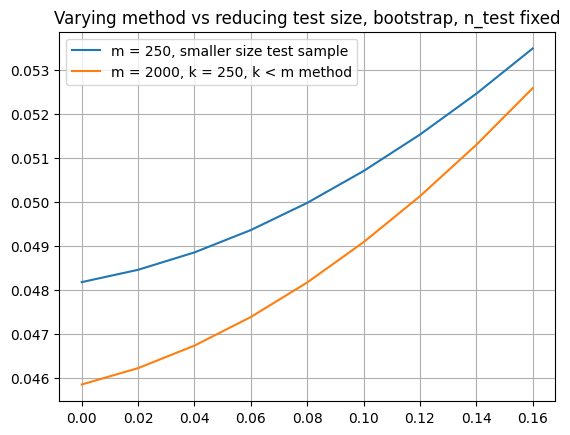

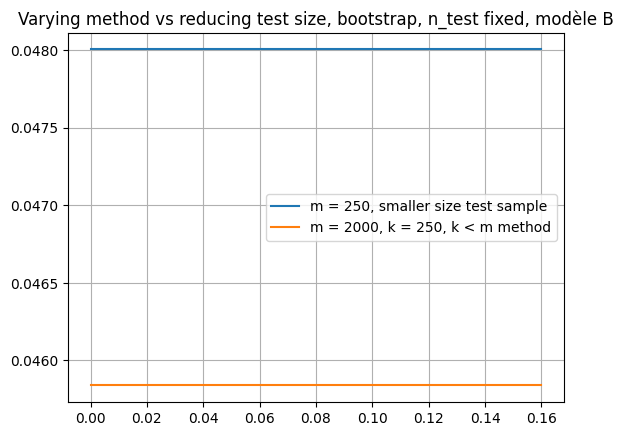

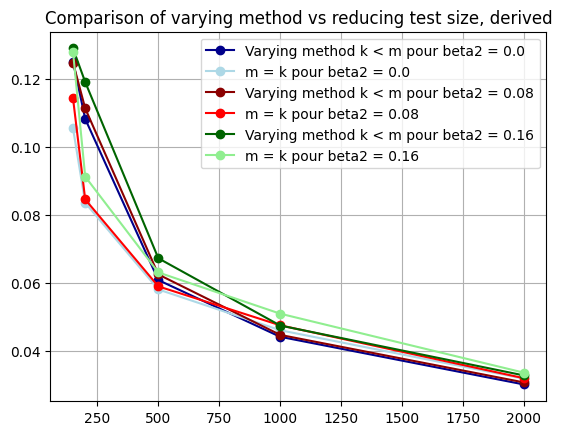

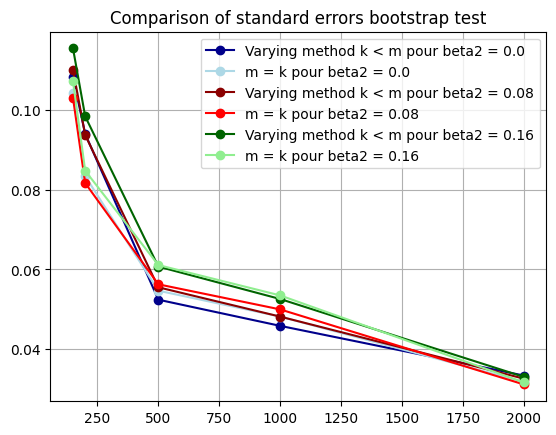

In [64]:
# Comparison of both methods

def plot_standard_error_both_methods():


    df_standard_error_A, df_standard_error_B = standard_error_test_large()
    df_se_bootstrap_A_test, df_se_bootstrap_B_test = standard_error_bootstrap_test()
    df_se_varying_k_A, df_se_varying_k_B = standard_error_varying_test_derived()
    df_se_varying_bootstrap_A_test, df_se_varying_bootstrap_B_test = standard_error_varying_bootstrapped_test()

    # Evolution for a given n_test value, changing beta2
    plt.figure()
    plt.title("Varying method vs reducing test size, bootstrap, n_test fixed")
    plt.plot(beta2_values, df_se_bootstrap_A_test[1000], label="m = 250, smaller size test sample")
    plt.plot(beta2_values, df_se_varying_bootstrap_A_test[1000], label="m = 2000, k = 250, k < m method")
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("Varying method vs reducing test size, bootstrap, n_test fixed, modèle B")
    plt.plot(beta2_values, df_se_bootstrap_B_test[1000], label="m = 250, smaller size test sample")
    plt.plot(beta2_values, df_se_varying_bootstrap_B_test[1000], label="m = 2000, k = 250, k < m method")
    plt.grid()
    plt.legend()
    plt.show()

    # Comparison for given values of beta2, changing n_test
    df4 = df_se_varying_k_A.loc[beta2_1]
    df5 = df_se_varying_k_A.loc[beta2_2]
    df6 = df_se_varying_k_A.loc[beta2_3]
    dff1 = df_standard_error_A.loc[beta2_1]
    dff2 = df_standard_error_A.loc[beta2_2]
    dff3 = df_standard_error_A.loc[beta2_3]

    plt.figure()
    plt.title("Comparison of varying method vs reducing test size, derived")
    plt.plot(df4.index, df4.values, marker='o', label=f"Varying method k < m pour beta2 = {beta2_1}", color="darkblue")
    plt.plot(dff1.index, dff1.values, marker='o', label=f"m = k pour beta2 = {beta2_1}", color="lightblue")
    plt.plot(df5.index, df5.values, marker='o', label=f"Varying method k < m pour beta2 = {beta2_2}", color="darkred")
    plt.plot(dff2.index, dff2.values, marker='o', label=f"m = k pour beta2 = {beta2_2}", color="red")
    plt.plot(df6.index, df6.values, marker='o', label=f"Varying method k < m pour beta2 = {beta2_3}", color="darkgreen")
    plt.plot(dff3.index, dff3.values, marker='o', label=f"m = k pour beta2 = {beta2_3}", color="lightgreen")
    plt.grid()
    plt.legend()
    plt.show()


    df1 = df_se_varying_bootstrap_A_test.loc[beta2_1]
    dff1 = df_se_bootstrap_A_test.loc[beta2_1]
    df2 = df_se_varying_bootstrap_A_test.loc[beta2_2]
    dff2 = df_se_bootstrap_A_test.loc[beta2_2]
    df3 = df_se_varying_bootstrap_A_test.loc[beta2_3]
    dff3 = df_se_bootstrap_A_test.loc[beta2_3]

    plt.figure()
    plt.title("Comparison of standard errors bootstrap test")
    plt.plot(df1.index, df1.values, marker='o', label=f"Varying method k < m pour beta2 = {beta2_1}", color="darkblue")
    plt.plot(dff1.index, dff1.values, marker='o', label=f"m = k pour beta2 = {beta2_1}", color="lightblue")
    plt.plot(df2.index, df2.values, marker='o', label=f"Varying method k < m pour beta2 = {beta2_2}", color="darkred")
    plt.plot(dff2.index, dff2.values, marker='o', label=f"m = k pour beta2 = {beta2_2}", color="red")
    plt.plot(df3.index, df3.values, marker='o', label=f"Varying method k < m pour beta2 = {beta2_3}", color="darkgreen")
    plt.plot(dff3.index, dff3.values, marker='o', label=f"m = k pour beta2 = {beta2_3}", color="lightgreen")
    plt.grid()
    plt.legend()
    plt.show()

plot_standard_error_both_methods()

### V - Confidence interval of the mean

### V.1 - Parametric method

In [65]:
# Creation d'un intervalle de confiance à partir de la formule dérivée de ses bornes
# bornes = moyenne empirique +/- student*erreur standard

def create_interval(lower, upper):
      return pd.Interval(left=lower, right=upper, closed='both')


def confidence_interval_mean():


   (stats_A_all, df_empirical_means_A, df_empirical_standard_deviations_A, df_medians_A, df_Q1_A, df_Q3_A, df_IQR_A,
     stats_B_all, df_empirical_means_B, df_empirical_standard_deviations_B, df_medians_B, df_Q1_B, df_Q3_B, df_IQR_B) = create_data()

   df_standard_error_A, df_standard_error_B = standard_error_test_large()

   t_critical = 1.96
   CI_lower_A = df_empirical_means_A - t_critical * df_standard_error_A
   CI_lower_B = df_empirical_means_B - t_critical * df_standard_error_B
   CI_upper_A = df_empirical_means_A + t_critical * df_standard_error_A
   CI_upper_B = df_empirical_means_B + t_critical * df_standard_error_B

   confidence_intervals_A = pd.DataFrame(index=CI_lower_A.index, columns=CI_lower_A.columns)
   confidence_intervals_B = pd.DataFrame(index=CI_lower_B.index, columns=CI_lower_B.columns)

   for col in CI_lower_A.columns:
    confidence_intervals_A[col] = CI_lower_A[col].combine(CI_upper_A[col], create_interval)

   for col in CI_lower_B.columns:
    confidence_intervals_B[col] = CI_lower_B[col].combine(CI_upper_B[col], create_interval)

   return confidence_intervals_A, confidence_intervals_B

### V.2 - Bootstrap

In [66]:
# Bootstrap pour trouver une loi de la moyenne, et sortir ses quartiles

def conf_each_bootstrap(n, B, m):

    np.random.seed(42)

    ci_bootstrap_A = []
    ci_bootstrap_B = []

    beta1 = 2
    B = 250
    alpha = 0.05
    epsilon = np.random.normal(0, 1, n + m)
    x = np.random.uniform(0, 5, n + m)

    x_train = x[:n]
    x_test = x[n:n+m]

    epsilon_train = epsilon[:n]
    epsilon_test = epsilon[n:n+m]

    bootstrap_indices = np.random.choice(m, size=(B, m), replace=True) # bootstrapping

    for beta2 in beta2_values:

        moy_boot_A = []
        moy_boot_B = []
        y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train

        for bootstrap_index in bootstrap_indices:

           x_test = x[bootstrap_index]
           y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

           model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
           y_pred_a = model_a.predict(x_test.reshape(-1, 1))
           pa = (y_test - y_pred_a)**2

           x_train_quad = np.column_stack((x_train, x_train**2))
           x_test_quad = np.column_stack((x_test, x_test**2))

           model_b = LinearRegression().fit(x_train_quad, y_train)
           y_pred_b = model_b.predict(x_test_quad)
           pb = (y_test - y_pred_b)**2

           moy_boot_A.append(np.mean(pa))
           moy_boot_B.append(np.mean(pb))

        lower_A = np.percentile(moy_boot_A, 100 * (alpha / 2))
        upper_A = np.percentile(moy_boot_A, 100 * (1 - alpha / 2))
        lower_B = np.percentile(moy_boot_B, 100 * (alpha / 2))
        upper_B = np.percentile(moy_boot_B, 100 * (1 - alpha / 2))

        ci_bootstrap_A.append(pd.Interval(left=lower_A, right=upper_A, closed='both'))
        ci_bootstrap_B.append(pd.Interval(left=lower_B, right=upper_B, closed='both'))

    return ci_bootstrap_A, ci_bootstrap_B

def confidence_interval_bootstrap():

   M = [150, 200, 500, 1000, 2000]

   liste_ci_bootstrap_A = []
   liste_ci_bootstrap_B = []

   for m in M:

      ci_bootstrap_A, ci_bootstrap_B = conf_each_bootstrap(150,250,m)

      liste_ci_bootstrap_A.append(ci_bootstrap_A)
      liste_ci_bootstrap_B.append(ci_bootstrap_B)

   df_ci_bootstrap_A = pd.DataFrame(liste_ci_bootstrap_A, index=M, columns=beta2_values).transpose()
   df_ci_bootstrap_B = pd.DataFrame(liste_ci_bootstrap_B, index=M, columns=beta2_values).transpose()

   return df_ci_bootstrap_A, df_ci_bootstrap_B


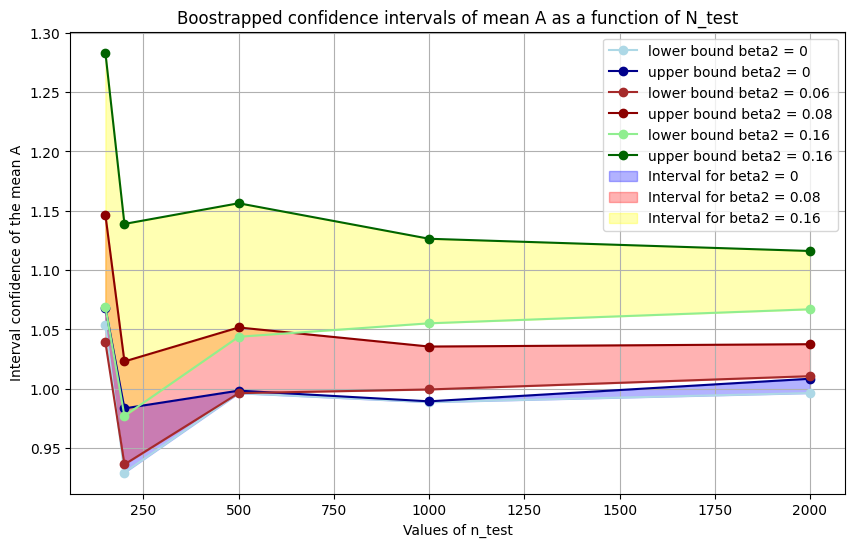

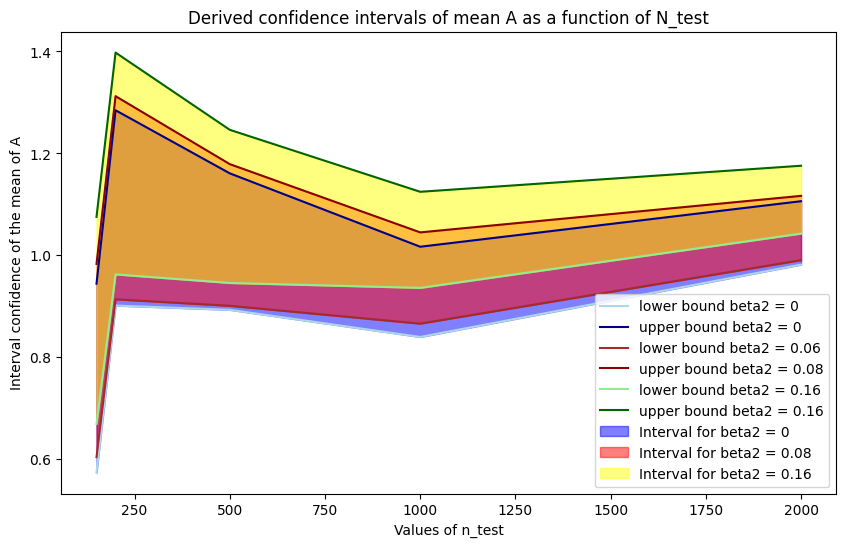

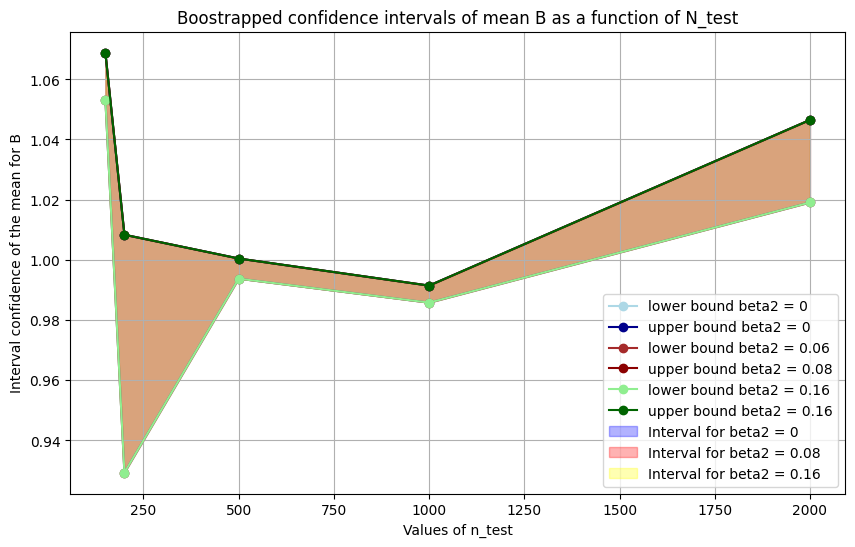

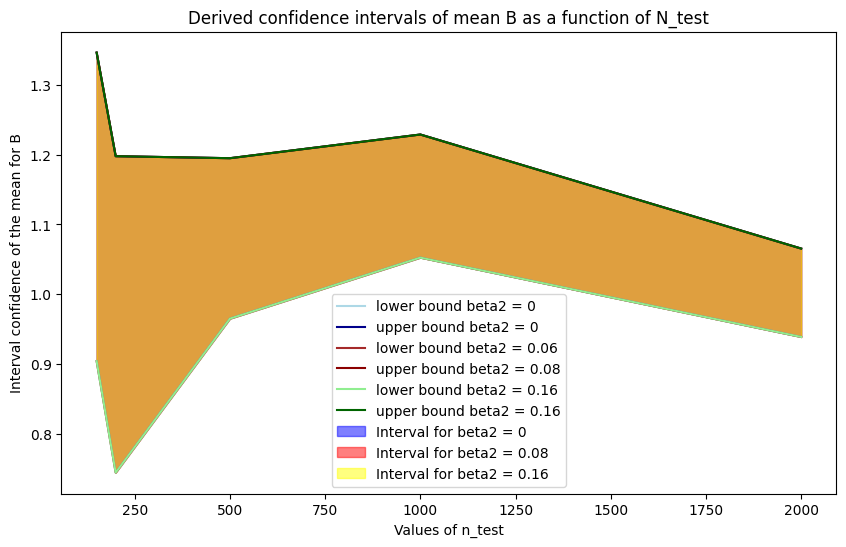

In [78]:
# Création des invtervalles de confiance pour A et B

def convert_intervals_to_list(df):
    return [(interval.left, interval.right) for interval in df]


def graphs_confidence_intervals_A():

    confidence_intervals_A, confidence_intervals_B = confidence_interval_mean()
    df_ci_bootstrap_A, df_ci_bootstrap_B = confidence_interval_bootstrap()

    df1 = df_ci_bootstrap_A.loc[beta2_1]
    df2 = df_ci_bootstrap_A.loc[beta2_2]
    df3 = df_ci_bootstrap_A.loc[beta2_3]
    df4 = confidence_intervals_A.loc[beta2_1]
    df5 = confidence_intervals_A.loc[beta2_2]
    df6 = confidence_intervals_A.loc[beta2_3]

    y_values = convert_intervals_to_list(df1)
    table_1 = convert_intervals_to_list(df2)
    table_2 = convert_intervals_to_list(df3)
    table_3 = convert_intervals_to_list(df4)
    table_4 = convert_intervals_to_list(df5)
    table_5 = convert_intervals_to_list(df6)

    x = [150, 200, 500, 1000, 2000]
    y1, y2 = zip(*y_values)
    y3, y4 = zip(*table_1)
    y5, y6 = zip(*table_2)
    y7, y8 = zip(*table_3)
    y9, y10 = zip(*table_4)
    y11, y12 = zip(*table_5)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label='lower bound beta2 = 0', marker='o', color="lightblue")
    plt.plot(x, y2, label='upper bound beta2 = 0', marker='o', color="darkblue")
    plt.plot(x, y3, label='lower bound beta2 = 0.06', marker='o', color="brown")
    plt.plot(x, y4, label='upper bound beta2 = 0.08', marker='o', color="darkred")
    plt.plot(x, y5, label='lower bound beta2 = 0.16', marker='o', color="lightgreen")
    plt.plot(x, y6, label='upper bound beta2 = 0.16', marker='o', color="darkgreen")

    plt.fill_between(x, y1, y2, color='blue', alpha=0.3, label='Interval for beta2 = 0')
    plt.fill_between(x, y3, y4, color='red', alpha=0.3, label='Interval for beta2 = 0.08')
    plt.fill_between(x, y5, y6, color='yellow', alpha=0.3, label='Interval for beta2 = 0.16')
    plt.xlabel('Values of n_test')
    plt.ylabel('Interval confidence of the mean A')
    plt.title('Boostrapped confidence intervals of mean A as a function of N_test')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(x, y7, label='lower bound beta2 = 0', color="lightblue")
    plt.plot(x, y8, label='upper bound beta2 = 0', color="darkblue")
    plt.plot(x, y9, label='lower bound beta2 = 0.06', color="brown")
    plt.plot(x, y10, label='upper bound beta2 = 0.08', color="darkred")
    plt.plot(x, y11, label='lower bound beta2 = 0.16', color="lightgreen")
    plt.plot(x, y12, label='upper bound beta2 = 0.16', color="darkgreen")

    plt.fill_between(x, y7, y8, color='blue', alpha=0.5, label='Interval for beta2 = 0')
    plt.fill_between(x, y9, y10, color='red', alpha=0.5, label='Interval for beta2 = 0.08')
    plt.fill_between(x, y11, y12, color='yellow', alpha=0.5, label='Interval for beta2 = 0.16')
    plt.xlabel('Values of n_test')
    plt.ylabel('Interval confidence of the mean of A')
    plt.title('Derived confidence intervals of mean A as a function of N_test')

    plt.legend()
    plt.show()

def graphs_confidence_intervals_B():
    confidence_intervals_A, confidence_intervals_B = confidence_interval_mean()
    df_ci_bootstrap_A, df_ci_bootstrap_B = confidence_interval_bootstrap()

    df1 = df_ci_bootstrap_B.loc[beta2_1]
    df2 = df_ci_bootstrap_B.loc[beta2_2]
    df3 = df_ci_bootstrap_B.loc[beta2_3]
    df4 = confidence_intervals_B.loc[beta2_1]
    df5 = confidence_intervals_B.loc[beta2_2]
    df6 = confidence_intervals_B.loc[beta2_3]

    y_values = convert_intervals_to_list(df1)
    table_1 = convert_intervals_to_list(df2)
    table_2 = convert_intervals_to_list(df3)
    table_3 = convert_intervals_to_list(df4)
    table_4 = convert_intervals_to_list(df5)
    table_5 = convert_intervals_to_list(df6)

    x = [150, 200, 500, 1000, 2000]
    y1, y2 = zip(*y_values)
    y3, y4 = zip(*table_1)
    y5, y6 = zip(*table_2)
    y7, y8 = zip(*table_3)
    y9, y10 = zip(*table_4)
    y11, y12 = zip(*table_5)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label='lower bound beta2 = 0', marker='o', color="lightblue")
    plt.plot(x, y2, label='upper bound beta2 = 0', marker='o', color="darkblue")
    plt.plot(x, y3, label='lower bound beta2 = 0.06', marker='o', color="brown")
    plt.plot(x, y4, label='upper bound beta2 = 0.08', marker='o', color="darkred")
    plt.plot(x, y5, label='lower bound beta2 = 0.16', marker='o', color="lightgreen")
    plt.plot(x, y6, label='upper bound beta2 = 0.16', marker='o', color="darkgreen")

    plt.fill_between(x, y1, y2, color='blue', alpha=0.3, label='Interval for beta2 = 0')
    plt.fill_between(x, y3, y4, color='red', alpha=0.3, label='Interval for beta2 = 0.08')
    plt.fill_between(x, y5, y6, color='yellow', alpha=0.3, label='Interval for beta2 = 0.16')
    plt.xlabel('Values of n_test')
    plt.ylabel('Interval confidence of the mean for B')
    plt.title('Boostrapped confidence intervals of mean B as a function of N_test')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(x, y7, label='lower bound beta2 = 0', color="lightblue")
    plt.plot(x, y8, label='upper bound beta2 = 0', color="darkblue")
    plt.plot(x, y9, label='lower bound beta2 = 0.06', color="brown")
    plt.plot(x, y10, label='upper bound beta2 = 0.08', color="darkred")
    plt.plot(x, y11, label='lower bound beta2 = 0.16', color="lightgreen")
    plt.plot(x, y12, label='upper bound beta2 = 0.16', color="darkgreen")

    plt.fill_between(x, y7, y8, color='blue', alpha=0.5, label='Interval for beta2 = 0')
    plt.fill_between(x, y9, y10, color='red', alpha=0.5, label='Interval for beta2 = 0.08')
    plt.fill_between(x, y11, y12, color='yellow', alpha=0.5, label='Interval for beta2 = 0.16')
    plt.xlabel('Values of n_test')
    plt.ylabel('Interval confidence of the mean for B')
    plt.title('Derived confidence intervals of mean B as a function of N_test')

    plt.legend()
    plt.show()

graphs_confidence_intervals_A()
graphs_confidence_intervals_B()

## VI - Inferential statistics : is a model better than the other


- Is model $\hat{f_A}$ obtained with method $A$ better/worse than model $\hat{f_B}$ obtained with method $B$?
  - Confidence interval for the difference
    - Derive formula or algorithm, using different approaches as done previously

    - Compute them for different subsets of the test sets of varying size $k \leq n$
  - Statistical testing
    - Parametric testing
      - Define hypotheses using $\mu_A$ and $\mu_B$
      - Write test statistic $T$ (e.g., using the standard error of the difference) and how it is distributed (e.g., $\sim t_{n-1}$, $\sim \mathcal{N}(0,1)$, etc.)

### VI.1 - Confidence interval for the difference

### VI.1.A - Derived method

In [68]:
# Récapitulatif de toutes les fonctions pour obtenir les informations sur la différence de performance

def descriptive_statistics_diff():

    n = 150

    M = [150, 200, 500, 1000, 2000]

    empirical_means_diff = []
    standard_deviations_diff = []

    for m in M:

      np.random.seed(42)
      beta1 = 2
      beta2_values_bis = [0.2, 0.3, 0.4, 0.5, 1]
      epsilon = np.random.normal(0, 1, n + m)
      x = np.random.uniform(0, 5, n + m)

      x_train = x[:n]
      x_test = x[n:n+m]

      epsilon_train = epsilon[:n]
      epsilon_test = epsilon[n:n+m]

      means = []
      stds =[]


      for beta2 in beta2_values:

          y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train
          y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

        # Linear Model : A
          model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
          y_pred_a = model_a.predict(x_test.reshape(-1, 1))
          pa = (y_test - y_pred_a)**2

        # Quadratic Model : B
          x_train_quad = np.column_stack((x_train, x_train**2))
          x_test_quad = np.column_stack((x_test, x_test**2))

          model_b = LinearRegression().fit(x_train_quad, y_train)
          y_pred_b = model_b.predict(x_test_quad)
          pb = (y_test - y_pred_b)**2

          differences = pa - pb

          mean = sum(differences)/m
          std = np.std(differences, ddof=1)
          means.append(mean)
          stds.append(std)

      empirical_means_diff.append(means)
      standard_deviations_diff.append(stds)

    return empirical_means_diff, standard_deviations_diff

def create_data_diff():

    M = [150, 200, 500, 1000, 2000]

    empirical_means_diff, standard_deviations_diff = descriptive_statistics_diff()

    df_empirical_means_diff = pd.DataFrame(empirical_means_diff, index=M, columns=beta2_values).transpose()
    df_empirical_standard_deviations_diff = pd.DataFrame(standard_deviations_diff, index=M, columns=beta2_values).transpose()


    return df_empirical_means_diff, df_empirical_standard_deviations_diff


def divide_by_sqrt(df):
    return df.apply(lambda x: x / np.sqrt(x.name), axis=0)

def standard_error_m_large_diff():

    df_empirical_means_diff, df_empirical_standard_deviations_diff = create_data_diff()

    df_standard_error_diff = divide_by_sqrt(df_empirical_standard_deviations_diff)

    return df_standard_error_diff


df_standard_error_diff = standard_error_m_large_diff()

def create_interval(lower, upper):
      return pd.Interval(left=lower, right=upper, closed='both')


def confidence_interval_mean_diff():


   df_empirical_means_diff, df_empirical_standard_deviations_diff = create_data_diff()

   df_standard_error_diff = standard_error_m_large_diff()

   t_critical = 1.96
   CI_lower_diff = df_empirical_means_diff - t_critical * df_standard_error_diff
   CI_upper_diff = df_empirical_means_diff + t_critical * df_standard_error_diff


   confidence_intervals_diff = pd.DataFrame(index=CI_lower_diff.index, columns=CI_lower_diff.columns)

   for col in CI_lower_diff.columns:
    confidence_intervals_diff[col] = CI_lower_diff[col].combine(CI_upper_diff[col], create_interval)


   return confidence_intervals_diff


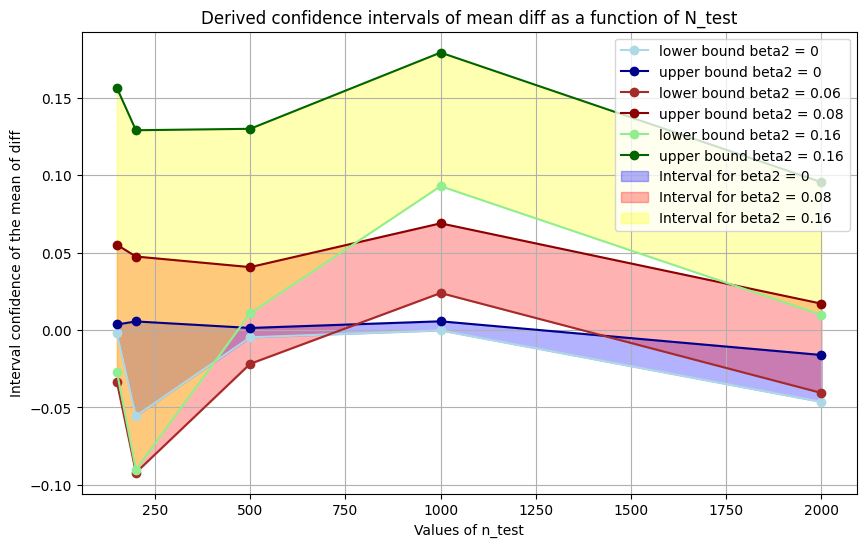

In [69]:
# Visualisation

def graphs_confidence_intervals_diff():

    confidence_intervals_diff = confidence_interval_mean_diff()

    df4 = confidence_intervals_diff.loc[beta2_1]
    df5 = confidence_intervals_diff.loc[beta2_2]
    df6 = confidence_intervals_diff.loc[beta2_3]

    y_values = convert_intervals_to_list(df4)
    table_1 = convert_intervals_to_list(df5)
    table_2 = convert_intervals_to_list(df6)


    x = [150, 200, 500, 1000, 2000]
    y1, y2 = zip(*y_values)
    y3, y4 = zip(*table_1)
    y5, y6 = zip(*table_2)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label='lower bound beta2 = 0', marker='o', color="lightblue")
    plt.plot(x, y2, label='upper bound beta2 = 0', marker='o', color="darkblue")
    plt.plot(x, y3, label='lower bound beta2 = 0.06', marker='o', color="brown")
    plt.plot(x, y4, label='upper bound beta2 = 0.08', marker='o', color="darkred")
    plt.plot(x, y5, label='lower bound beta2 = 0.16', marker='o', color="lightgreen")
    plt.plot(x, y6, label='upper bound beta2 = 0.16', marker='o', color="darkgreen")

    plt.fill_between(x, y1, y2, color='blue', alpha=0.3, label='Interval for beta2 = 0')
    plt.fill_between(x, y3, y4, color='red', alpha=0.3, label='Interval for beta2 = 0.08')
    plt.fill_between(x, y5, y6, color='yellow', alpha=0.3, label='Interval for beta2 = 0.16')
    plt.xlabel('Values of n_test')
    plt.ylabel('Interval confidence of the mean of diff')
    plt.title('Derived confidence intervals of mean diff as a function of N_test')
    plt.legend()
    plt.grid(True)
    plt.show()
    
graphs_confidence_intervals_diff()

### VI.1.B - Bootstrapped

In [70]:
# Construction des intervalles de confiance bootstrapp

def conf_each_bootstrap_diff(n, B, m):

    np.random.seed(42)

    ci_bootstrap_diff = []

    beta1 = 2
    B = 250
    alpha = 0.05
    epsilon = np.random.normal(0, 1, n + m)
    x = np.random.uniform(0, 5, n + m)

    x_train = x[:n]
    x_test = x[n:n+m]

    epsilon_train = epsilon[:n]
    epsilon_test = epsilon[n:n+m]

    bootstrap_indices = np.random.choice(m, size=(B, m), replace=True) # bootstrapping

    for beta2 in beta2_values:

        moy_boot = []
        y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train

        for bootstrap_index in bootstrap_indices:

           x_test = x[bootstrap_index]
           y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

           model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
           y_pred_a = model_a.predict(x_test.reshape(-1, 1))
           pa = (y_test - y_pred_a)**2

           x_train_quad = np.column_stack((x_train, x_train**2))
           x_test_quad = np.column_stack((x_test, x_test**2))

           model_b = LinearRegression().fit(x_train_quad, y_train)
           y_pred_b = model_b.predict(x_test_quad)
           pb = (y_test - y_pred_b)**2

           difference = pa - pb

           moy_boot.append(np.mean(difference))


        lower_A = np.percentile(moy_boot, 100 * (alpha / 2))
        upper_A = np.percentile(moy_boot, 100 * (1 - alpha / 2))


        ci_bootstrap_diff.append(pd.Interval(left=lower_A, right=upper_A, closed='both'))

    return ci_bootstrap_diff

def confidence_interval_bootstrap_diff():

   M = [150, 200, 500, 1000, 2000]

   liste_ci_bootstrap_diff = []

   for m in M:

      ci_bootstrap_diff = conf_each_bootstrap_diff(150,250,m)

      liste_ci_bootstrap_diff.append(ci_bootstrap_diff)

   df_ci_bootstrap_diff = pd.DataFrame(liste_ci_bootstrap_diff, index=M, columns=beta2_values).transpose()

   return df_ci_bootstrap_diff

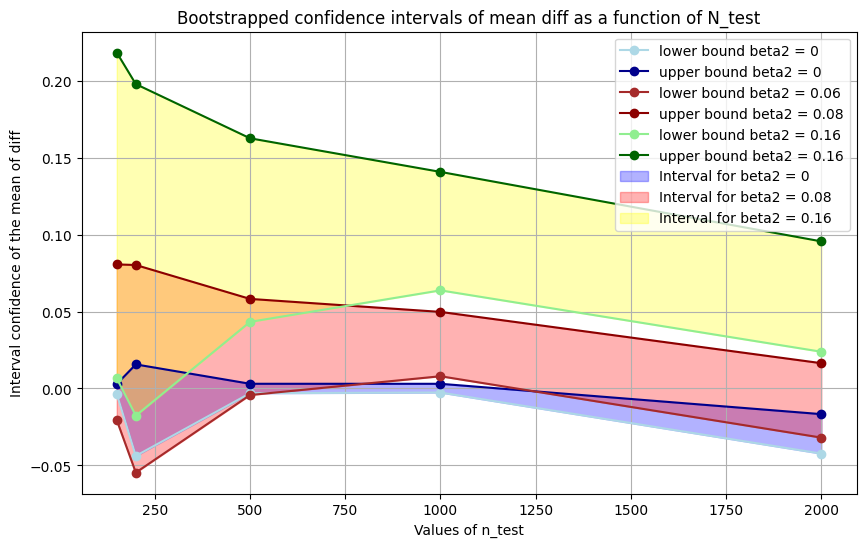

In [71]:
# Visualisation des intervalles

def graphs_confidence_intervals_boot_diff():

    df_ci_bootstrap_diff = confidence_interval_bootstrap_diff()

    df4 = df_ci_bootstrap_diff.loc[beta2_1]
    df5 = df_ci_bootstrap_diff.loc[beta2_2]
    df6 = df_ci_bootstrap_diff.loc[beta2_3]

    y_values = convert_intervals_to_list(df4)
    table_1 = convert_intervals_to_list(df5)
    table_2 = convert_intervals_to_list(df6)

    x = [150, 200, 500, 1000, 2000]
    y1, y2 = zip(*y_values)
    y3, y4 = zip(*table_1)
    y5, y6 = zip(*table_2)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label='lower bound beta2 = 0', marker='o', color="lightblue")
    plt.plot(x, y2, label='upper bound beta2 = 0', marker='o', color="darkblue")
    plt.plot(x, y3, label='lower bound beta2 = 0.06', marker='o', color="brown")
    plt.plot(x, y4, label='upper bound beta2 = 0.08', marker='o', color="darkred")
    plt.plot(x, y5, label='lower bound beta2 = 0.16', marker='o', color="lightgreen")
    plt.plot(x, y6, label='upper bound beta2 = 0.16', marker='o', color="darkgreen")

    plt.fill_between(x, y1, y2, color='blue', alpha=0.3, label='Interval for beta2 = 0')
    plt.fill_between(x, y3, y4, color='red', alpha=0.3, label='Interval for beta2 = 0.08')
    plt.fill_between(x, y5, y6, color='yellow', alpha=0.3, label='Interval for beta2 = 0.16')
    plt.xlabel('Values of n_test')
    plt.ylabel('Interval confidence of the mean of diff')
    plt.title('Bootstrapped confidence intervals of mean diff as a function of N_test')
    plt.legend()
    plt.grid(True)
    plt.show()

graphs_confidence_intervals_boot_diff()

### VI.2 - Statistical testing

L'hypothèse nulle $H_0$ et l'hypothèse alternative $H_1$ sont définies comme suit :
\begin{align*}
H_0 &: \mu_A > \mu_B \\
H_1 &: \mu_A =< \mu_B
\end{align*}

La statistique de test se calcule comme le rapport de la moyenne empirique de la différence D = A - B, $m_D$ divisée par l'erreur standard de la moyenne de D, $SE(\overline{D})$ :
$$
T = \frac{m_D}{SE(\overline{D})}
$$

### VI.2.A - Parametric testing

In [72]:
# Ajout de la statistique de test et de la puissance

def power_1():

    standard_errors = []
    test_statistics = []
    p_values_bil = []
    p_values_right = []
    power_bil = []
    power_right = []
    epsilon = np.random.normal(0, 1, n + m)
    x = np.random.uniform(0, 5, n + m)

    x_train = x[:n]
    x_test = x[n:n+m]
    epsilon_train = epsilon[:n]
    epsilon_test = epsilon[n:n+m]

    for beta2 in beta2_values:

        y_train = beta1 * x_train + beta2 * x_train **2 + epsilon_train
        y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

        # Linear Model
        model_a1 = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
        y_pred_a1 = model_a1.predict(x_test.reshape(-1, 1))
        pa = (y_test-y_pred_a1)**2

            # Quadratic Model
        x_train_quad = np.column_stack((x_train, x_train**2))
        x_test_quad = np.column_stack((x_test, x_test**2))
        model_a2 = LinearRegression().fit(x_train_quad, y_train)
        y_pred_a2 = model_a2.predict(x_test_quad)
        pb = (y_test-y_pred_a2)**2

        diff = pa - pb

        d_barre = np.mean(diff)
        se = np.std(diff)/(m**0.5)

        test_stat = d_barre/se # Statistique pour l'hypothèse nulle

        student_bil = stats.t.ppf(0.975, df=m-1)
        p_value_bil = 1 - stats.t.cdf(abs(test_stat), df = m-1)
        student_right = stats.t.ppf(0.95, df=m-1)
        p_value_right = 1 - stats.t.cdf(test_stat, df=m-1)

        test_bil = student_bil - test_stat
        test_right = student_right - test_stat
        puissance_bil = 1 - stats.norm.cdf(test_bil, 0, 1)
        puissance_right = 1 - stats.norm.cdf(test_right, 0, 1)

        standard_errors.append(se)
        test_statistics.append(test_stat)
        p_values_bil.append(p_value_bil)
        p_values_right.append(p_value_right)
        power_bil.append(puissance_bil)
        power_right.append(puissance_right)

    return  standard_errors, test_statistics, p_values_bil, p_values_right, power_bil, power_right


standard_errors, test_statistics, p_values_bil, p_values_right, power_bil, power_right = power_1()

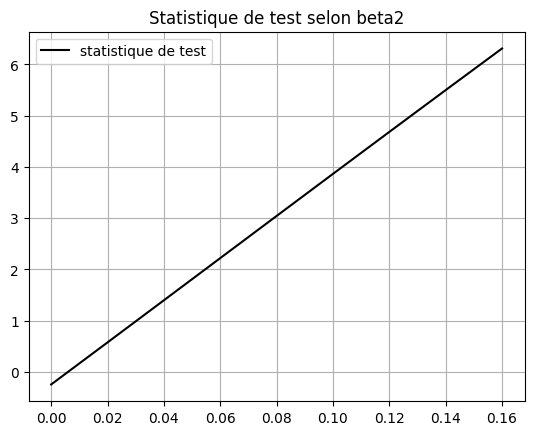

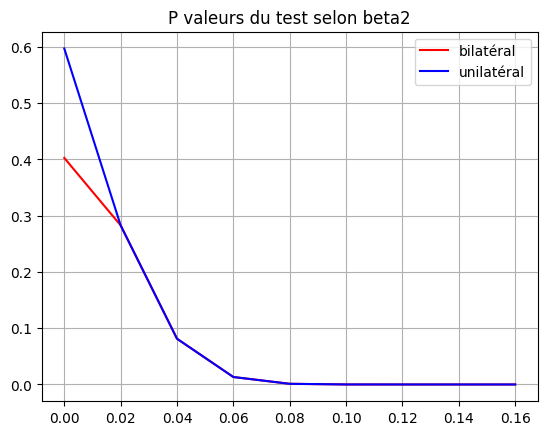

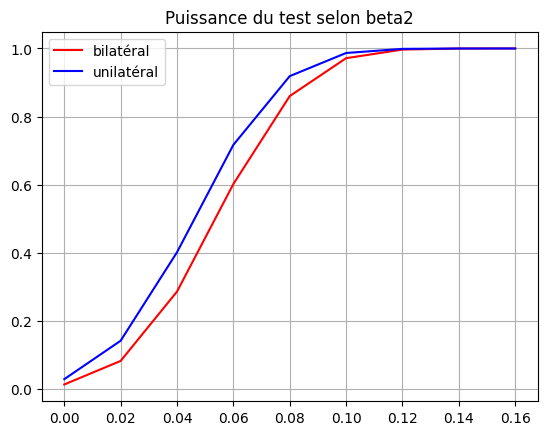

In [73]:

plt.figure()
plt.title("Statistique de test selon beta2")
plt.plot(beta2_values, test_statistics, label = "statistique de test", color = "black")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.title("P valeurs du test selon beta2")
plt.plot(beta2_values, p_values_bil, label = "bilatéral", color = "r")
plt.plot(beta2_values, p_values_right, label = "unilatéral", color = "b")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.title("Puissance du test selon beta2")
plt.plot(beta2_values, power_bil, label = "bilatéral", color = "r")
plt.plot(beta2_values, power_right, label = "unilatéral", color = "b")
plt.grid()
plt.legend()
plt.show()


### VI.2.B - Bootstrapped

In [74]:
# On ajoute du bootstrapping dans le test

def power_boot():

    standard_errors = []
    test_statistics = []
    p_values_bil = []
    p_values_right = []
    power_bil = []
    power_right = []
    epsilon = np.random.normal(0, 1, n + m)
    x = np.random.uniform(0, 5, n + m)

    x_train = x[:n]
    epsilon_train = epsilon[:n]
    epsilon_test = epsilon[n:n+m]

    B = 250
    bootstrap_indices = np.random.choice(m, size=(B, m), replace=True) # bootstrapping

    for beta2 in beta2_values:

        moy_boot_diff = []
        y_train = beta1 * x_train + beta2 * x_train**2 + epsilon_train

        for bootstrap_index in bootstrap_indices:

           x_test = x[bootstrap_index]
           y_test = beta1 * x_test + beta2 * x_test**2 + epsilon_test

           model_a = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
           y_pred_a = model_a.predict(x_test.reshape(-1, 1))
           pa = (y_test - y_pred_a)**2

           x_train_quad = np.column_stack((x_train, x_train**2))
           x_test_quad = np.column_stack((x_test, x_test**2))

           model_b = LinearRegression().fit(x_train_quad, y_train)
           y_pred_b = model_b.predict(x_test_quad)
           pb = (y_test - y_pred_b)**2

           diff = pa - pb

           moy_boot_diff.append(np.mean(diff))

        d_barre = np.mean(moy_boot_diff)
        se = np.std(moy_boot_diff)

        test_stat = d_barre/se # Statistique pour l'hypothèse nulle

        student_bil = stats.t.ppf(0.975, df=m-1)
        p_value_bil = 1 - stats.t.cdf(abs(test_stat), df = m-1)
        student_right = stats.t.ppf(0.95, df=m-1)
        p_value_right = 1 - stats.t.cdf(test_stat, df=m-1)

        test_bil = student_bil - test_stat
        test_right = student_right - test_stat
        puissance_bil = 1 - stats.norm.cdf(test_bil, 0, 1)
        puissance_right = 1 - stats.norm.cdf(test_right, 0, 1)

        standard_errors.append(se)
        test_statistics.append(test_stat)
        p_values_bil.append(p_value_bil)
        p_values_right.append(p_value_right)
        power_bil.append(puissance_bil)
        power_right.append(puissance_right)

    return  standard_errors, test_statistics, p_values_bil, p_values_right, power_bil, power_right


standard_errors_boot, test_statistics_boot, p_values_bil_boot, p_values_right_boot, power_bil_boot, power_right_boot = power_boot()


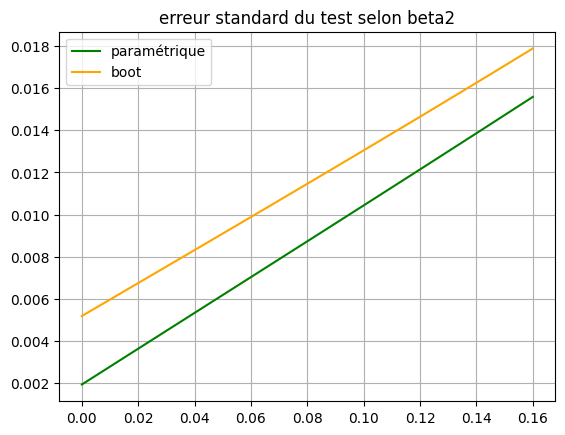

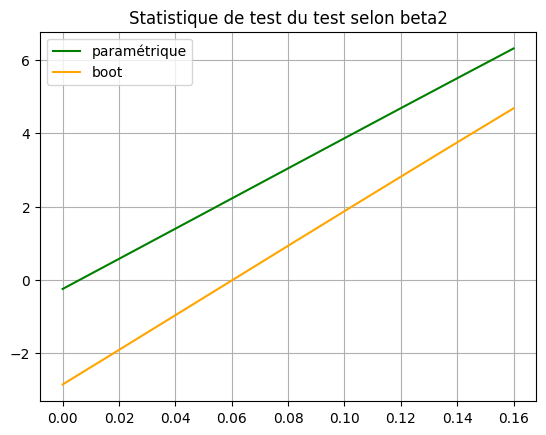

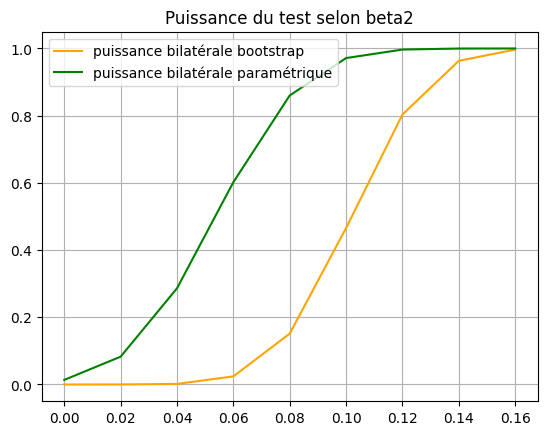

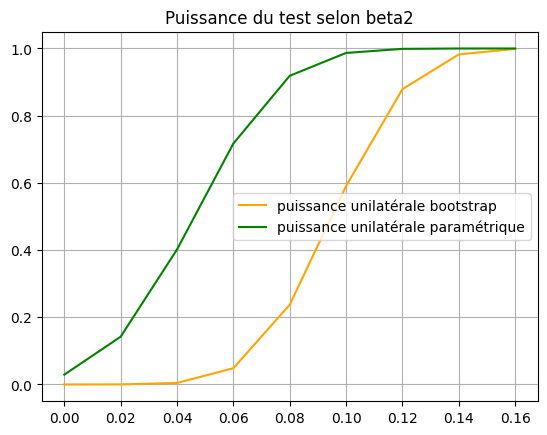

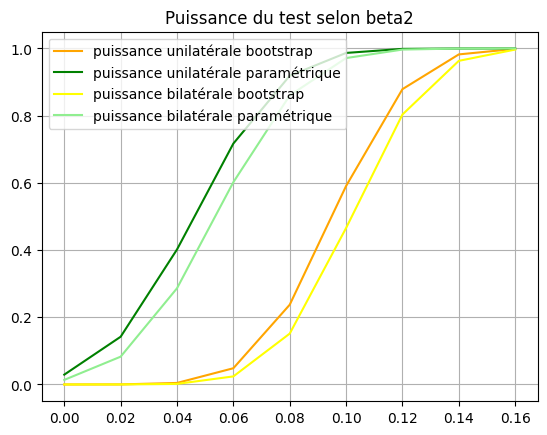

In [75]:

plt.figure()
plt.title("erreur standard du test selon beta2")
plt.plot(beta2_values, standard_errors, label = "paramétrique", color = "green")
plt.plot(beta2_values, standard_errors_boot, label = "boot", color = "orange")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.title("Statistique de test du test selon beta2")
plt.plot(beta2_values, test_statistics, label = "paramétrique", color = "green")
plt.plot(beta2_values, test_statistics_boot, label = "boot", color = "orange")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.title("Puissance du test selon beta2")
plt.plot(beta2_values, power_bil_boot, label = "puissance bilatérale bootstrap", color = "orange")
plt.plot(beta2_values, power_bil, label = "puissance bilatérale paramétrique", color = "green")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.title("Puissance du test selon beta2")
plt.plot(beta2_values, power_right_boot, label = "puissance unilatérale bootstrap", color = "orange")
plt.plot(beta2_values, power_right, label = "puissance unilatérale paramétrique", color = "green")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.title("Puissance du test selon beta2")
plt.plot(beta2_values, power_right_boot, label = "puissance unilatérale bootstrap", color = "orange")
plt.plot(beta2_values, power_right, label = "puissance unilatérale paramétrique", color = "green")
plt.plot(beta2_values, power_bil_boot, label = "puissance bilatérale bootstrap", color = "yellow")
plt.plot(beta2_values, power_bil, label = "puissance bilatérale paramétrique", color = "lightgreen")
plt.grid()
plt.legend()
plt.show()


### VI.2.C - Permutation test

In [76]:
def power_simulation_with_permutation_2(n_permutations=1000):

    power_perm = []
    standard_errors = []
    test_statistics = []
    permutation_p_values = []

    beta1 = 2
    epsilon = np.random.normal(0, 1, n + m)
    x = np.random.uniform(0, 5, n + m)

    x_train = x[:n]
    x_test = x[n:n+m]
    epsilon_train = epsilon[:n]
    epsilon_test = epsilon[n:n+m]

    for beta2 in beta2_values:
        y_train = beta1 * x_train + beta2 * x_train ** 2 + epsilon_train
        y_test = beta1 * x_test + beta2 * x_test ** 2 + epsilon_test

        # Linear Model
        model_a1 = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
        y_pred_a1 = model_a1.predict(x_test.reshape(-1, 1))
        pa = (y_test - y_pred_a1) ** 2

        # Quadratic Model
        x_train_quad = np.column_stack((x_train, x_train ** 2))
        x_test_quad = np.column_stack((x_test, x_test ** 2))
        model_a2 = LinearRegression().fit(x_train_quad, y_train)
        y_pred_a2 = model_a2.predict(x_test_quad)
        pb = (y_test - y_pred_a2) ** 2

        diff = pa - pb
        d_barre = np.mean(diff)
        se = np.std(diff) / (m ** 0.5)
        test_stat = d_barre / se

        perm_stats = []
        for _ in range(n_permutations):
            perm_indices = np.random.permutation(m)
            perm_diff = pa[perm_indices] - pb
            perm_d_barre = np.mean(perm_diff)
            perm_stats.append(perm_d_barre / se)

        perm_stats = np.array(perm_stats)

        p_value = (np.sum(perm_stats >= test_stat) + 1) / (n_permutations + 1)
        permutation_p_values.append(p_value)


        perm_student = stats.t.ppf(0.975, df=m-1)
        perm_test_alt = perm_student - perm_stats
        perm_puissance = 1 - stats.norm.cdf(perm_test_alt, 0, 1)

        power_perm.append(np.mean(perm_puissance))

        standard_errors.append(se)
        test_statistics.append(test_stat)

    return standard_errors, test_statistics, power_perm, permutation_p_values

standard_errors_perm_2, test_statistics_perm_2, power_perm_2, permutation_p_values_2 = power_simulation_with_permutation_2()

print("Standard Errors:", standard_errors_perm_2)
print("Test Statistics:", test_statistics_perm_2)
print("Power (Permutation):", power_perm_2)
print("Permutation P-values:", permutation_p_values_2)

Standard Errors: [0.0015392716178169296, 0.0032989727514516364, 0.005052505250441719, 0.006802204474020502, 0.008550418953872697, 0.010299505253487055, 0.012051822734156996, 0.013809728275853769, 0.015575571002305938]
Test Statistics: [-1.7761398916086644, -0.944064624138292, -0.10797503755152107, 0.7310476146453734, 1.5718991080426266, 2.4134593516713436, 3.2545997608970643, 4.094190787075653, 4.93110948744141]
Power (Permutation): [9.300668292944181e-05, 0.0018349984164658713, 0.019267110775844025, 0.1093291175955635, 0.348544754652395, 0.6744764185751446, 0.9020719799561941, 0.9835392515212789, 0.9985107979927877]
Permutation P-values: [0.5094905094905094, 0.5304695304695305, 0.4855144855144855, 0.5584415584415584, 0.6593406593406593, 0.6273726273726273, 0.5894105894105894, 0.8331668331668332, 0.996003996003996]


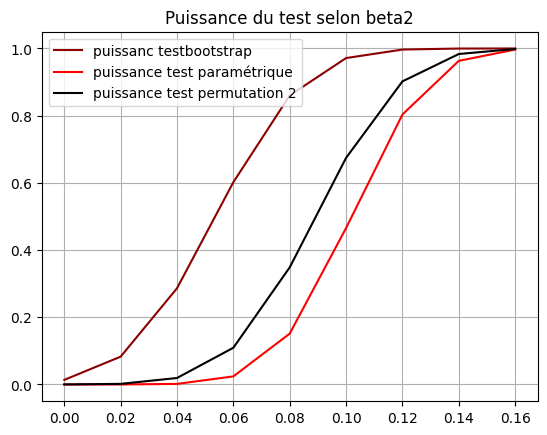

In [77]:
plt.figure()
plt.title("Puissance du test selon beta2")
plt.plot(beta2_values, power_bil, label = "puissanc testbootstrap", color = "darkred")
plt.plot(beta2_values, power_bil_boot, label = "puissance test paramétrique", color = "red")
plt.plot(beta2_values, power_perm_2, label = "puissance test permutation 2", color = "black")
plt.grid()
plt.legend()
plt.show()

### VI.2.D - Non parametric testing